In [ ]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
from sklearn.datasets import load_iris
from statsmodels.formula.api import quantreg, wls
from statsmodels.iolib.summary2 import summary_col
from PIL import Image
from statsmodels.stats.stattools import durbin_watson
from collections import OrderedDict

In [ ]:
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {'MAE': mae, 'RMSE': rmse, 'R²': r2}

def print_metrics(metrics, dataset_type):
    print(f"{dataset_type} Metrics:")
    print(f"  MAE: {metrics['MAE']:.4f}")
    print(f"  RMSE: {metrics['RMSE']:.4f}")
    print(f"  R²: {metrics['R²']:.4f}")

def evaluate_predictions(predictions, true_values, target_name="TargetVariable", time_values=None):
    """
    Evaluate model predictions against true values with metrics and visualizations.

    Args:
        predictions (pd.Series or np.ndarray): Model's predicted values.
        true_values (pd.Series or np.ndarray): True values from the dataset.
        target_name (str): Name of the target variable (for labeling plots and messages).
        time_values (pd.Series): Time values corresponding to the data for coloring.

    Returns:
        dict: Dictionary of metrics including MAE, RMSE, R², and percentage errors.
    """
    # Ensure inputs are aligned
    if isinstance(predictions, np.ndarray):
        predictions = pd.Series(predictions, index=true_values.index)

    # Calculate metrics
    metrics = calculate_metrics(true_values, predictions)

    # Print metrics
    print_metrics(metrics, dataset_type=f"Test - {target_name}")

    # Range of the target variable
    target_min = true_values.min()
    target_max = true_values.max()
    target_range = target_max - target_min
    print(f"{target_name} Range: Min = {target_min}, Max = {target_max}, Range = {target_range}")

    # Percentage errors
    mae_percentage = (metrics['MAE'] / target_range) * 100
    rmse_percentage = (metrics['RMSE'] / target_range) * 100

    print(f"MAE as percentage of range: {mae_percentage:.2f}%")
    print(f"RMSE as percentage of range: {rmse_percentage:.2f}%")

    # Extract years for coloring
    if time_values is not None:
        unique_years = time_values.unique()
        norm = mcolors.Normalize(vmin=min(unique_years), vmax=max(unique_years))
        cmap = cm.viridis
        colors = cmap(norm(time_values))
    else:
        colors = 'blue'  # Default color if no time_values provided

    # Visualizations
    # Scatter plot: Predicted vs Actual
    plt.scatter(true_values, predictions, c=colors, alpha=0.6)
    plt.plot([target_min, target_max], [target_min, target_max], 'r--', label='Perfect prediction')  # Perfect prediction line
    plt.title(f'Predicted vs. Actual {target_name}')
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel(f'Predicted {target_name}')
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label='Year')
    plt.legend()
    plt.show()

    # Residuals plot
    residuals = true_values - predictions
    plt.scatter(true_values, residuals, c=colors, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
    plt.title(f'Residuals vs. Actual {target_name}')
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel('Residuals')
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label='Year')
    plt.legend()
    plt.show()

    # Return metrics and percentages
    return {
        "Metrics": metrics,
        "MAE_Percentage": mae_percentage,
        "RMSE_Percentage": rmse_percentage
    }

In [ ]:
def evaluate_predictions_country(predictions, true_values, target_name="TargetVariable", country_values=None, title="Country"):
    """
    Evaluate model predictions against true values with metrics and visualizations.

    Args:
        predictions (pd.Series or np.ndarray): Model's predicted values.
        true_values (pd.Series or np.ndarray): True values from the dataset.
        target_name (str): Name of the target variable (for labeling plots and messages).
        country_values (pd.Series or np.ndarray): Country values corresponding to the data for coloring.

    Returns:
        dict: Dictionary of metrics including MAE, RMSE, R², and percentage errors.
    """
    import random
    from matplotlib.colors import ListedColormap

    # Ensure inputs are aligned
    if isinstance(predictions, np.ndarray):
        predictions = pd.Series(predictions, index=true_values.index)

    # Calculate metrics
    metrics = calculate_metrics(true_values, predictions)

    # Print metrics
    print_metrics(metrics, dataset_type=f"Test - {target_name}")

    # Range of the target variable
    target_min = true_values.min()
    target_max = true_values.max()
    target_range = target_max - target_min
    print(f"{target_name} Range: Min = {target_min}, Max = {target_max}, Range = {target_range}")

    # Percentage errors
    mae_percentage = (metrics['MAE'] / target_range) * 100
    rmse_percentage = (metrics['RMSE'] / target_range) * 100

    print(f"MAE as percentage of range: {mae_percentage:.2f}%")
    print(f"RMSE as percentage of range: {rmse_percentage:.2f}%")

    # Generate distinct colors for each unique country
    if country_values is not None:
        unique_countries = np.unique(country_values)
        num_countries = len(unique_countries)

        # Generate a list of random, unique colors
        random.seed(42)  # Ensures reproducibility
        colors = [
            (random.random(), random.random(), random.random())
            for _ in range(num_countries)
        ]
        cmap = ListedColormap(colors)

        # Map each country to a unique color
        color_mapping = {country: colors[idx] for idx, country in enumerate(unique_countries)}
        dot_colors = [color_mapping[country] for country in country_values]
    else:
        dot_colors = 'blue'  # Default color if no country_values provided
        color_mapping = None

    # Visualizations
    # Scatter plot: Predicted vs Actual
    plt.figure(figsize=(10, 6))
    plt.scatter(true_values, predictions, c=dot_colors, alpha=0.6)
    plt.plot([target_min, target_max], [target_min, target_max], 'r--', label='Perfect prediction')  # Perfect prediction line
    plt.title(f'Predicted vs. Actual {target_name}')
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel(f'Predicted {target_name}')
    if country_values is not None:
        handles = [
            plt.Line2D([0], [0], marker='o', color=color_mapping[country], linestyle='', label=country)
            for country in unique_countries
        ]
        plt.legend(handles=handles, title=title, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    # Residuals plot
    plt.figure(figsize=(10, 6))
    residuals = true_values - predictions
    plt.scatter(true_values, residuals, c=dot_colors, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
    plt.title(f'Residuals vs. Actual {target_name}')
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel('Residuals')
    if country_values is not None:
        plt.legend(handles=handles, title=title, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    # Return metrics and percentages
    return {
        "Metrics": metrics,
        "MAE_Percentage": mae_percentage,
        "RMSE_Percentage": rmse_percentage
    }

# 1) First model

In [ ]:
first_model = pd.read_csv("first_normalise_another.csv")
first_model_importance = pd.read_csv('filtered_data_another_set_importance.csv')

| Model Description           | MAE (Train) | RMSE (Train) | R² (Train) | MAE (Test) | RMSE (Test) | R² (Test) | DayAheadPriceEUR Coef | Std Err | t-Stat  | P-value | 95% CI Low | 95% CI High |
|----------------------------|-------------|--------------|------------|------------|-------------|-----------|------------------------|---------|---------|---------|------------|-------------|
| **Base DML Model**         | 0.0619      | 0.0816       | 0.8187     | 0.0896     | 0.1201      | 0.6210    | -0.000372              | 0.000178| -2.094  | 0.0362  | -0.00072   | -0.000024   |
| **Standard IV Regression** | N/A         | N/A          | 0.5610     | N/A        | N/A         | 0.5610    | -0.0005                | 0.0001  | -3.188  | 0.0014  | -0.0008    | -0.0002     |
| **DML with 50 Top Features**| 0.0990     | 0.1302       | 0.5377     | 0.1036     | 0.1366      | 0.5089    | -0.000668              | 0.000171| -3.916  | 0.00009 | -0.001002  | -0.000334   |


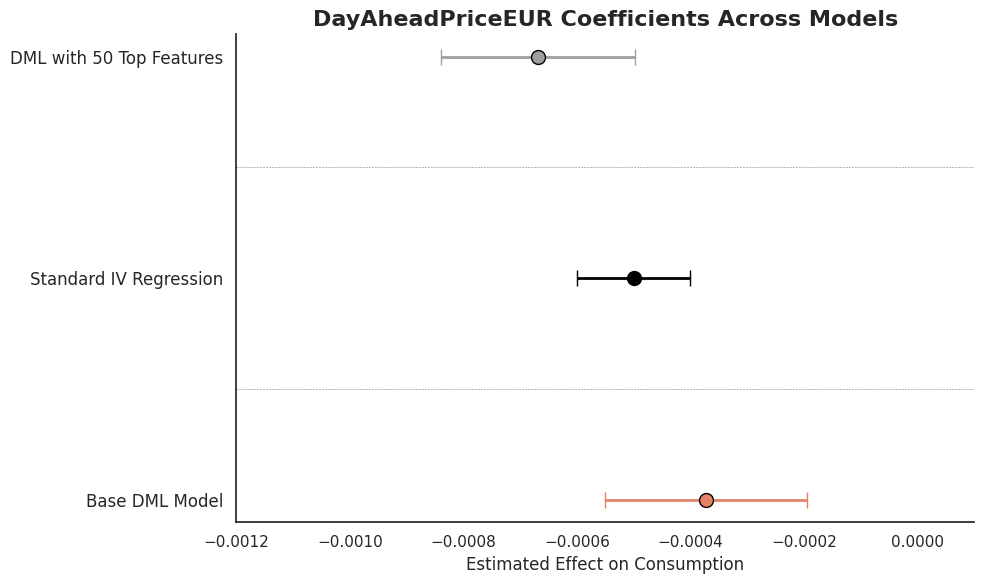

In [ ]:
df_models = pd.DataFrame({
    'Model': [
        'Base DML Model',
        'Standard IV Regression',
        'DML with 50 Top Features'
    ],
    'Coefficient': [-0.000372, -0.0005, -0.000668],
    'Std_Error': [0.000178, 0.0001, 0.000171]
})

# Assign spaced y-axis positions
df_models['y_pos'] = [0, 2, 4]

# Plot setup
plt.figure(figsize=(10, 6))
sns.set_style("white")  # clean white background
palette = sns.color_palette("RdGy", len(df_models))

# Manually override the second color to black
palette[1] = "black"

# Plot each coefficient with error bars
for i, row in df_models.iterrows():
    plt.errorbar(
        x=row['Coefficient'],
        y=row['y_pos'],
        xerr=row['Std_Error'],
        fmt='o',
        color=palette[i],
        capsize=6,
        markersize=10,
        linewidth=2,
        markeredgecolor='black'
    )

# Optional: horizontal separators between groups
for y in [1, 3]:
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.4)

# Customize axes
plt.yticks(df_models['y_pos'], df_models['Model'], fontsize=12)
plt.xticks(fontsize=11)
plt.xlim(-0.0012, 0.0001)
plt.xlabel("Estimated Effect on Consumption", fontsize=12)
plt.title("DayAheadPriceEUR Coefficients Across Models", fontsize=16, weight='bold')

# Clean up plot style
sns.despine(top=True, right=True, left=False, bottom=False)

# Final layout and save
plt.tight_layout()
plt.savefig("price_coef_comparison_rdgy_black_iv.png", dpi=300)
plt.show()



# Second model  CIV(Wt | Pt → Dt | Wt−1,...,Wt−50)

| Model Description                  | MAE (Train) | RMSE (Train) | R² (Train) | MAE (Test) | RMSE (Test) | R² (Test) | DayAheadPriceEUR Coef | Std Err | t-Stat  | P-value | 95% CI Low | 95% CI High |
|-----------------------------------|-------------|--------------|------------|------------|-------------|-----------|------------------------|---------|---------|---------|------------|-------------|
| DML with 50 IV Lags               | 0.0874      | 0.1121       | 0.6576     | 0.1006     | 0.1301      | 0.5550    | -0.000469              | 0.000312| -1.503  | 0.1328  | -0.001081  |  0.000143   |
| Standard IV Regression            | N/A         | N/A          | 0.5687     | N/A        | N/A         | 0.5687    | -0.0004                | 0.0004  | -0.929  | 0.3531  | -0.0012    |  0.0004     |
| DML with 50 IV Lags + Importance  | 0.0874      | 0.1121       | 0.6575     | 0.1003     | 0.1296      | 0.5581    | -0.000805              | 0.000225| -3.576  | 0.0003  | -0.001246  | -0.000364   |



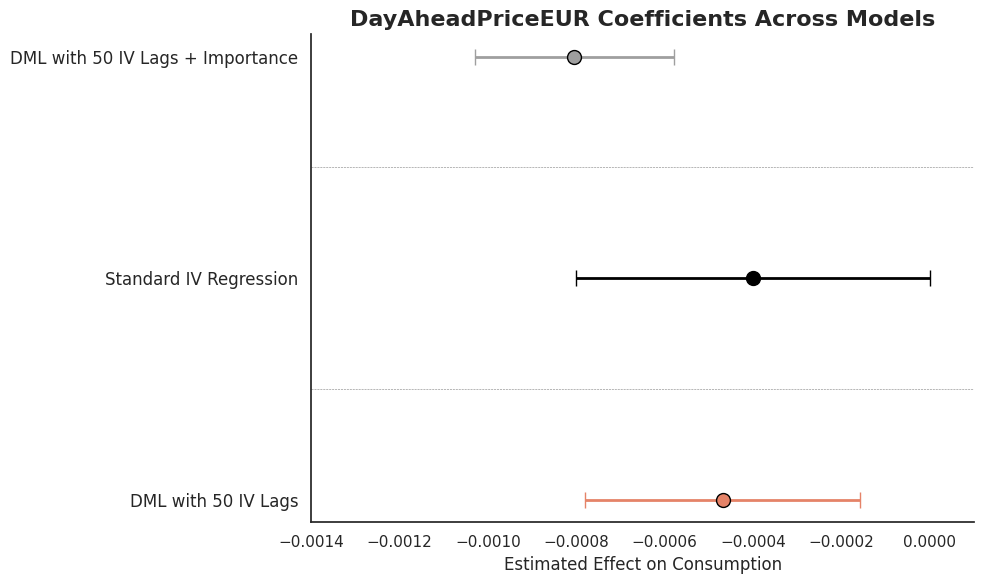

In [ ]:
df_models = pd.DataFrame({
    'Model': [
        'DML with 50 IV Lags',
        'Standard IV Regression',
        'DML with 50 IV Lags + Importance'
    ],
    'Coefficient': [-0.000469, -0.0004, -0.000805],
    'Std_Error': [0.000312, 0.0004, 0.000225]
})

# Assign spaced y-axis positions
df_models['y_pos'] = [0, 2, 4]

# Plot setup
plt.figure(figsize=(10, 6))
sns.set_style("white")  # clean white background
palette = sns.color_palette("RdGy", len(df_models))

# Make second model (IV) black
palette[1] = "black"

# Plot each coefficient with error bars
for i, row in df_models.iterrows():
    plt.errorbar(
        x=row['Coefficient'],
        y=row['y_pos'],
        xerr=row['Std_Error'],
        fmt='o',
        color=palette[i],
        capsize=6,
        markersize=10,
        linewidth=2,
        markeredgecolor='black'
    )

# Optional: horizontal separators between models
for y in [1, 3]:
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.4)

# Customize axes
plt.yticks(df_models['y_pos'], df_models['Model'], fontsize=12)
plt.xticks(fontsize=11)
plt.xlim(-0.0014, 0.0001)
plt.xlabel("Estimated Effect on Consumption", fontsize=12)
plt.title("DayAheadPriceEUR Coefficients Across Models", fontsize=16, weight='bold')

# Clean up plot style
sns.despine(top=True, right=True, left=False, bottom=False)

# Final layout and save
plt.tight_layout()
plt.show()


# Third model CIV(Wt|Pt→Dt|Dt−1)

| Model Description            | MAE (Train) | RMSE (Train) | R² (Train) | MAE (Test) | RMSE (Test) | R² (Test) | DayAheadPriceEUR Coef | Std Err   | t-Stat   | P-value | 95% CI Low | 95% CI High |
|-----------------------------|-------------|--------------|------------|------------|-------------|-----------|------------------------|-----------|----------|---------|-------------|--------------|
| CIV(Wt\|Pt→Dt\|Dt−1)        | 0.0260      | 0.0361       | 0.9645     | 0.0275     | 0.0388      | 0.9603    | -0.000052              | 0.000013  | -4.106   | 0.00004 | -0.000076   | -0.000027    |


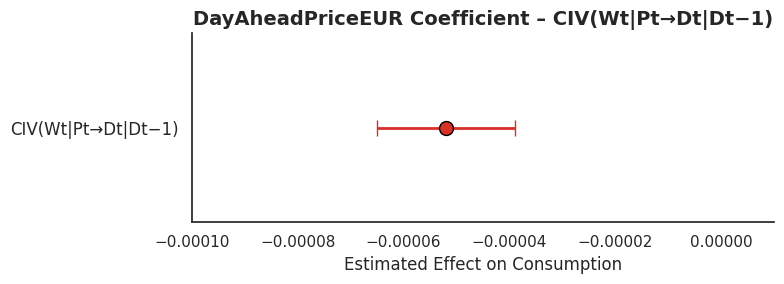

In [ ]:
df_civ = pd.DataFrame({
    'Model': ['CIV(Wt|Pt→Dt|Dt−1)'],
    'Coefficient': [-0.000052],
    'Std_Error': [0.000013],
    'y_pos': [0]
})

# Plot setup
plt.figure(figsize=(8, 3))
sns.set_style("white")
palette = ['#d73027']  # a red shade from RdGy

# Plot the coefficient with error bar
row = df_civ.iloc[0]
plt.errorbar(
    x=row['Coefficient'],
    y=row['y_pos'],
    xerr=row['Std_Error'],
    fmt='o',
    color=palette[0],
    capsize=6,
    markersize=10,
    linewidth=2,
    markeredgecolor='black'
)

# Customize axes
plt.yticks(df_civ['y_pos'], df_civ['Model'], fontsize=12)
plt.xticks(fontsize=11)
plt.xlim(-0.0001, 0.00001)
plt.xlabel("Estimated Effect on Consumption", fontsize=12)
plt.title("DayAheadPriceEUR Coefficient – CIV(Wt|Pt→Dt|Dt−1)", fontsize=14, weight='bold')

# Clean up plot
sns.despine(top=True, right=True, left=False, bottom=False)

# Final layout and show
plt.tight_layout()
plt.savefig("civ_coef_plot.png", dpi=300)
plt.show()

# Fourth model CIV(Wt, Wt−1 | (Pt, Dt−1) → Dt | ∅)



| **Model Description**                     | **MAE (Train)** | **RMSE (Train)** | **R² (Train)** | **MAE (Test)** | **RMSE (Test)** | **R² (Test)** | **DayAheadPriceEUR Coef** | **Std Err** | **t-Stat** | **P-value** | **95% CI Low** | **95% CI High** |
|------------------------------------------|-----------------|------------------|----------------|----------------|------------------|----------------|----------------------------|-------------|------------|-------------|----------------|-----------------|
| **CIV(Wt,Wt−1 | (Pt,Dt−1) → Dt | ∅)**     | 0.0876          | 0.1123           | 0.6564         | 0.1009         | 0.1303           | 0.5534         | -0.001442                   | 0.000359    | -4.012     | 0.000060    | -0.002146      | -0.000737       |
| **IV Regression (same setting)**          | N/A             | N/A              | 0.5687         | N/A            | N/A              | 0.5687         | -0.000800                   | 0.000700    | -1.287     | 0.1981      | -0.002100      | 0.000400        |
| **CIV (with Importance-based Selection)** | 0.0877          | 0.1124           | 0.6557         | 0.1008         | 0.1301           | 0.5553         | -0.001112                   | 0.000176    | -6.329     | 2.47e-10    | -0.001456      | -0.000768       |


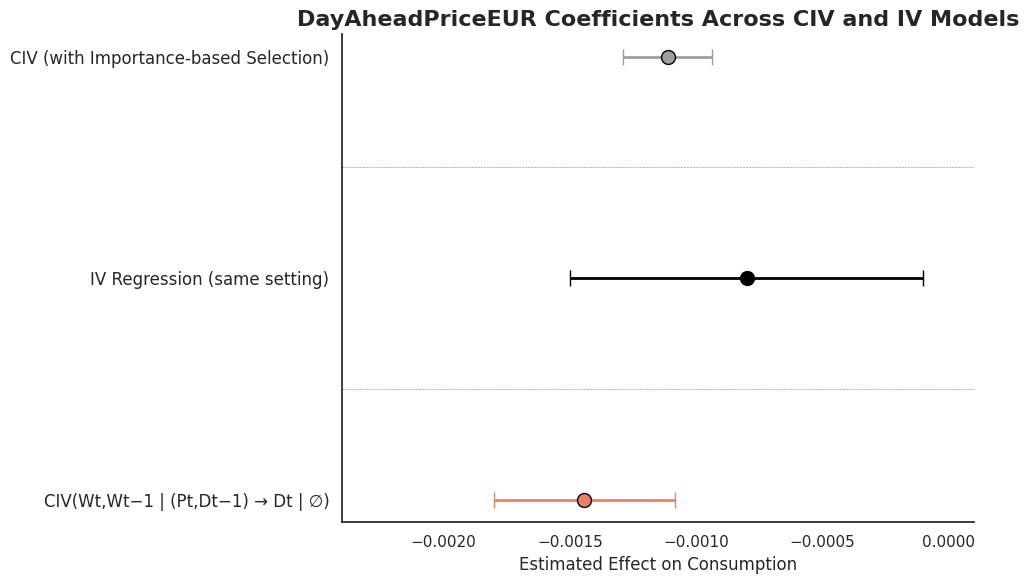

In [ ]:
df_civ_models = pd.DataFrame({
    'Model': [
        'CIV(Wt,Wt−1 | (Pt,Dt−1) → Dt | ∅)',
        'IV Regression (same setting)',
        'CIV (with Importance-based Selection)'
    ],
    'Coefficient': [-0.001442, -0.000800, -0.001112],
    'Std_Error': [0.000359, 0.000700, 0.000176]
})

# Assign spaced y-axis positions
df_civ_models['y_pos'] = [0, 2, 4]

# Plot setup
plt.figure(figsize=(10, 6))
sns.set_style("white")  # clean white background
palette = sns.color_palette("RdGy", len(df_civ_models))
palette[1] = "black"  # Make the IV model black for emphasis

# Plot each coefficient with error bars
for i, row in df_civ_models.iterrows():
    plt.errorbar(
        x=row['Coefficient'],
        y=row['y_pos'],
        xerr=row['Std_Error'],
        fmt='o',
        color=palette[i],
        capsize=6,
        markersize=10,
        linewidth=2,
        markeredgecolor='black'
    )

# Horizontal separators
for y in [1, 3]:
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.4)

# Customize axes
plt.yticks(df_civ_models['y_pos'], df_civ_models['Model'], fontsize=12)
plt.xticks(fontsize=11)
plt.xlim(-0.0024, 0.0001)
plt.xlabel("Estimated Effect on Consumption", fontsize=12)
plt.title("DayAheadPriceEUR Coefficients Across CIV and IV Models", fontsize=16, weight='bold')

# Final layout and show
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()
plt.show()

# Fifth CIV(Wt,Wt−1, Wt-2 | (Pt,Pt−1,Dt−1) → Dt | ∅)¶

| Model Description              | MAE (Train) | RMSE (Train) | R² (Train) | MAE (Test) | RMSE (Test) | R² (Test) | DayAheadPriceEUR Coef | Std Err  | t-Stat  | P-value  | 95% CI Low | 95% CI High |
|-------------------------------|-------------|--------------|------------|------------|-------------|-----------|------------------------|----------|---------|----------|------------|-------------|
| **Base CIV Model**            | 0.0876      | 0.1124       | 0.6560     | 0.1003     | 0.1296      | 0.5581    | -0.001174              | 0.000249 | -4.715  | 0.000002 | -0.001663  | -0.000686   |
| **Standard IV Regression**    | N/A         | N/A          | N/A        | N/A        | N/A         | 0.5581    | -0.0019                | 0.0008   | -2.189  | 0.0286   | -0.0035    | -0.0002     |
| **CIV with Top Features**     | 0.0987      | 0.1283       | 0.5516     | 0.1032     | 0.1345      | 0.5242    | -0.000809              | 0.000251 | -3.216  | 0.0013   | -0.001301  | -0.000316   |


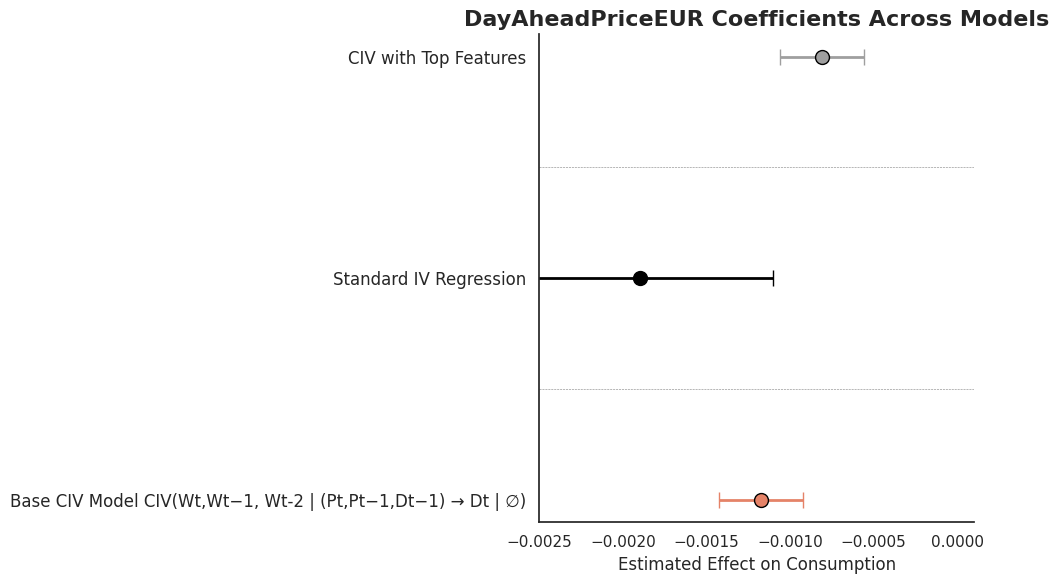

In [ ]:
df_models = pd.DataFrame({
    'Model': [
        'Base CIV Model CIV(Wt,Wt−1, Wt-2 | (Pt,Pt−1,Dt−1) → Dt | ∅)',
        'Standard IV Regression',
        'CIV with Top Features'
    ],
    'Coefficient': [-0.001174, -0.0019, -0.000809],
    'Std_Error': [0.000249, 0.0008, 0.000251]
})

# Assign y-axis positions to space out the models visually
df_models['y_pos'] = [0, 2, 4]

# Plot setup
plt.figure(figsize=(10, 6))
sns.set_style("white")  # Clean background
palette = sns.color_palette("RdGy", len(df_models))
palette[1] = "black"  # Make IV model black for distinction

# Plot each coefficient with error bars
for i, row in df_models.iterrows():
    plt.errorbar(
        x=row['Coefficient'],
        y=row['y_pos'],
        xerr=row['Std_Error'],
        fmt='o',
        color=palette[i],
        capsize=6,
        markersize=10,
        linewidth=2,
        markeredgecolor='black'
    )

# Optional: horizontal separator lines
for y in [1, 3]:
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.4)

# Customize axes
plt.yticks(df_models['y_pos'], df_models['Model'], fontsize=12)
plt.xticks(fontsize=11)
plt.xlim(-0.0025, 0.0001)
plt.xlabel("Estimated Effect on Consumption", fontsize=12)
plt.title("DayAheadPriceEUR Coefficients Across Models", fontsize=16, weight='bold')

# Final styling
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()
plt.show()

# Models together

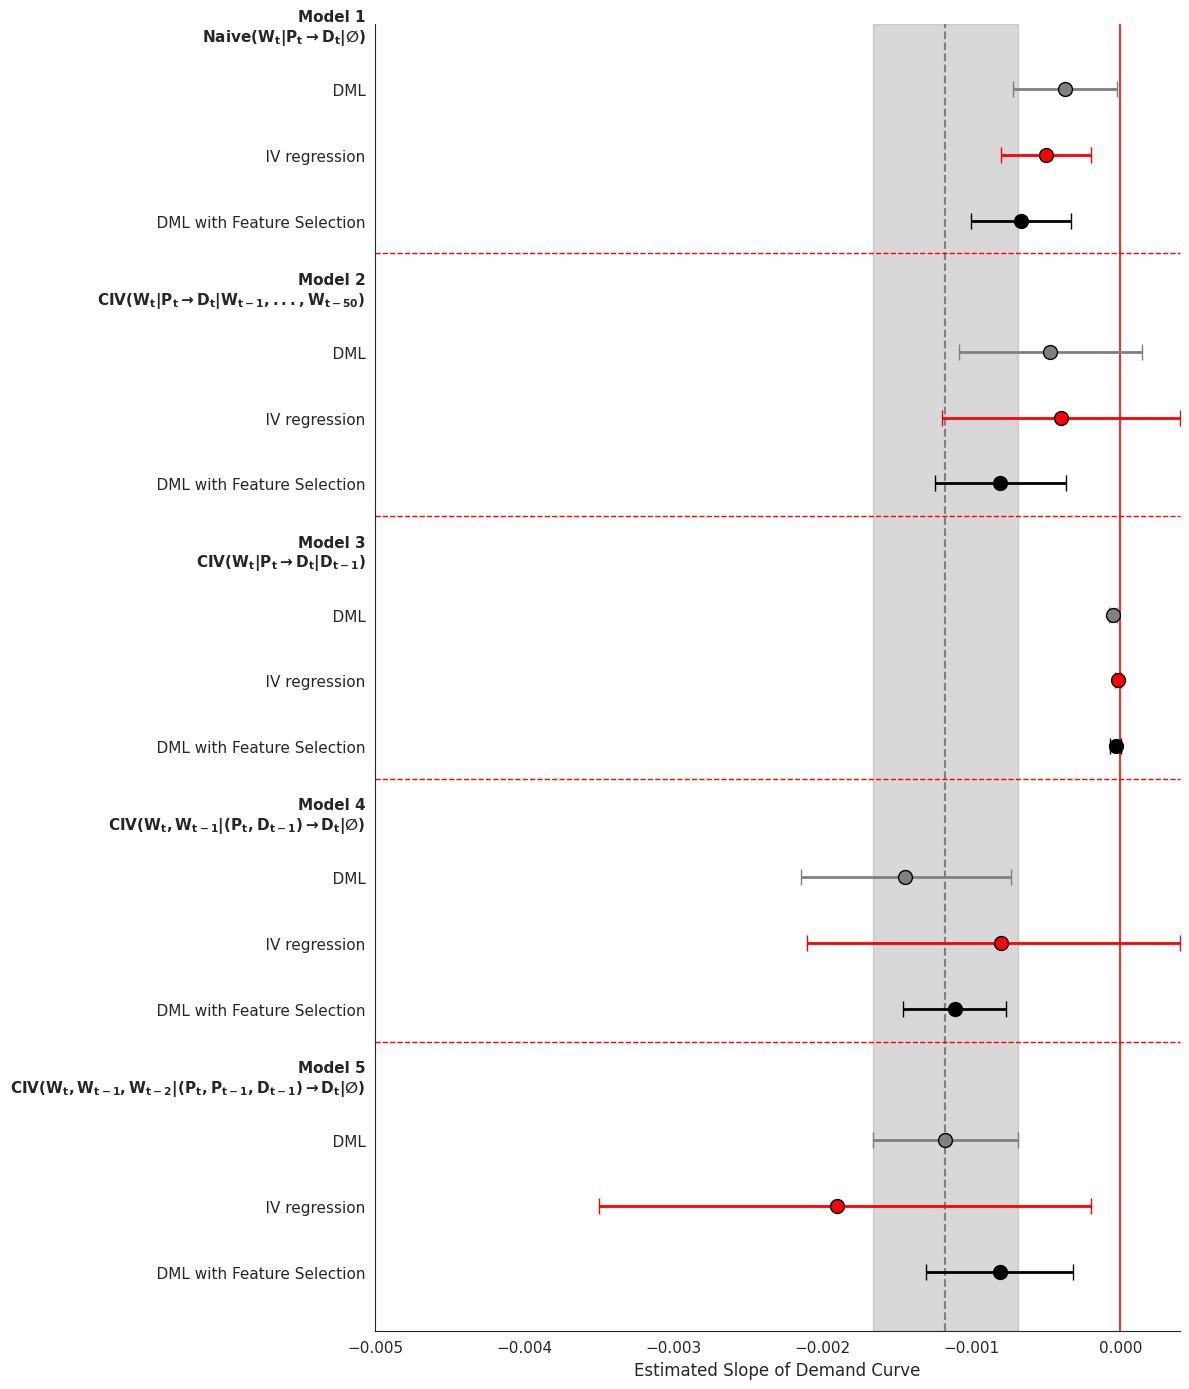

In [ ]:
block_equations = {
    "Model 1": r"$\mathbf{Naive(W_t|P_t \to D_t|\varnothing)}$",
    "Model 2": r"$\mathbf{CIV(W_t|P_t \to D_t|W_{t-1},...,W_{t-50})}$",
    "Model 3": r"$\mathbf{CIV(W_t|P_t \to D_t|D_{t-1})}$",
    "Model 4": r"$\mathbf{CIV(W_t, W_{t-1}|(P_t,D_{t-1}) \to D_t|\varnothing)}$",
    "Model 5": r"$\mathbf{CIV(W_t,W_{t-1},W_{t-2}|(P_t,P_{t-1},D_{t-1}) \to D_t|\varnothing)}$"
}



combined_models = pd.DataFrame({
    'Group': [
        '(1) Simple DML (Wt|Pt→Dt|∅)', '(1) Simple DML (Wt|Pt→Dt|∅)', '(1) Simple DML (Wt|Pt→Dt|∅)',
        '(2) DML (Wt|Pt→Dt|Wt−1,...,Wt−50)', '(2) DML (Wt|Pt→Dt|Wt−1,...,Wt−50)', '(2) DML (Wt|Pt→Dt|Wt−1,...,Wt−50)',
        '(3) DML (Wt|Pt→Dt|Dt−1)',  '(3) DML (Wt|Pt→Dt|Dt−1)', '(3) DML (Wt|Pt→Dt|Dt−1)',
        '(4) DML (Wt,Wt−1|(Pt,Dt−1)→Dt|∅)', '(4) DML (Wt,Wt−1|(Pt,Dt−1)→Dt|∅)', '(4) DML (Wt,Wt−1|(Pt,Dt−1)→Dt|∅)',
        '(5) DML (Wt,Wt−1, Wt−2|(Pt,Pt−1,Dt−1)→Dt|∅)', '(5) DML (Wt,Wt−1, Wt−2|(Pt,Pt−1,Dt−1)→Dt|∅)', '(5) DML (Wt,Wt−1, Wt−2|(Pt,Pt−1,Dt−1)→Dt|∅)',
    ],
    'Model': [
        'DML',
        'IV regression',
        'DML with Feature Selection',
        'DML',
        'IV regression',
        'DML with Feature Selection',
        'DML',
        'IV regression',
        'DML with Feature Selection',
        'DML',
        'IV regression',
        'DML with Feature Selection',
        'DML',
        'IV regression',
        'DML with Feature Selection'
    ],
    'Coefficient': [
        -0.000372, -0.0005, -0.000668,
        -0.000469, -0.0004, -0.000805,
        -0.000051,  -0.00001884, -0.000032,
        -0.001442, -0.000800, -0.001112,
        -0.001174, -0.0019, -0.000809
    ],
    'CI_Low': [
        -0.000720, -0.000800, -0.001002,
        -0.001081, -0.001200, -0.001246,
        -0.000078, -0.00003908, -0.000068,
        -0.002146, -0.002100, -0.001456,
        -0.001663, -0.003500, -0.001301
    ],
    'CI_High': [
        -0.000024, -0.000200, -0.000334,
        0.000143, 0.000400, -0.000364,
        -0.000024, 0.000001399, 0.000004,
        -0.000737, 0.000400, -0.000768,
        -0.000686, -0.000200, -0.000316
    ]
})

# Step 1: Create Group and Block
combined_models['Block'] = combined_models['Group'].apply(lambda x: f"Model {x.split(')')[0].replace('(', '')}")

# Step 2: Create the plot order (block headers + models inside)
plot_rows = []
for block in combined_models['Block'].unique():
    plot_rows.append({'Block': block, 'Model': block, 'is_block': True, 'Coefficient': None, 'CI_Low': None, 'CI_High': None})
    block_models = combined_models[combined_models['Block'] == block]
    for _, row in block_models.iterrows():
        row_dict = row.to_dict()
        row_dict['is_block'] = False
        plot_rows.append(row_dict)

plot_df = pd.DataFrame(plot_rows)
plot_df['y_pos'] = range(len(plot_df))

# Step 3: Colors
def model_color(model_name, is_block):
    if is_block:
        return 'white'
    if 'with Feature Selection' in model_name:
        return 'black'
    elif 'IV regression' in model_name or 'IV Regression' in model_name:
        return 'red'
    else:
        return 'gray'

colors = [model_color(m, b) for m, b in zip(plot_df['Model'], plot_df['is_block'])]

# Step 4: Plotting
plt.figure(figsize=(12, 14))  # narrower but taller
sns.set_style("white")


# Highlight Base CIV model area
base_model = combined_models[
    (combined_models['Group'] == '(5) DML (Wt,Wt−1, Wt−2|(Pt,Pt−1,Dt−1)→Dt|∅)') &
    (combined_models['Model'] == 'DML')
].iloc[0]

plt.axvspan(base_model['CI_Low'], base_model['CI_High'], color='grey', alpha=0.3)

# Base and zero lines
plt.axvline(base_model['Coefficient'], color='grey', linestyle='--', linewidth=1.5)
plt.axvline(0, color='red', linestyle='-', linewidth=1.2)

# Plot points
for i, row in plot_df.iterrows():
    if not row['is_block']:
        lower_error = row['Coefficient'] - row['CI_Low']
        upper_error = row['CI_High'] - row['Coefficient']
        plt.errorbar(
            x=row['Coefficient'],
            y=row['y_pos'],
            xerr=[[lower_error], [upper_error]],
            fmt='o',
            color=colors[i],
            capsize=6,
            markersize=10,
            linewidth=2,
            markeredgecolor='black'
        )

# IMPORTANT: get current axis
ax = plt.gca()

# Add separator lines that cross into labels
for i, (model, is_block) in enumerate(zip(plot_df['Model'], plot_df['is_block'])):
    if is_block and i != 0:
        ax.plot(
            [0, 1],  # full width in axis coordinates
            [i - 0.5, i - 0.5],  # flat horizontal line
            color='red',
            linestyle='--',
            linewidth=1,
            transform=ax.get_yaxis_transform(),
            clip_on=False
        )


labels = []
for model, is_block in zip(plot_df['Model'], plot_df['is_block']):
    if is_block:
        labels.append(f"{model}\n{block_equations.get(model, '')}")
    else:
        labels.append("    " + model)



plt.gca().invert_yaxis()
plt.xticks(fontsize=11)
plt.xlim(-0.005, 0.0004)

# Custom yticks + bold block labels
plt.gca().set_yticks(plot_df['y_pos'])
text_objs = plt.gca().set_yticklabels(labels, fontsize=11)
for text, is_block in zip(text_objs, plot_df['is_block']):
    if is_block:
        text.set_weight('bold')
plt.xlabel("Estimated Slope of Demand Curve", fontsize=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()
plt.savefig("my_plot.png", dpi=600, bbox_inches='tight')
plt.show()


#Coef. by years

In [ ]:
fold_coefficients_deamnd_lag_tretm_dem = pd.read_csv("fold_coefficients_2lags_tretm_dem_price.csv")
fold_coefficients_deamnd_lag_tretm_dem

,Year,coef,se,t,p
0,2017,[-0.00194898 -0.41556335 -0.00193421],[0.00078291 0.10351947 0.00078564],[-2.48938976 -4.01434956 -2.46193718],[1.27962598e-02 5.96099493e-05 1.38188868e-02]
1,2018,[-0.00290721 1.41987566 -0.00290716],[0.00070301 0.1073642 0.00070386],[-4.13537246 13.22485213 -4.13028666],[3.54379384e-05 6.30611340e-40 3.62311187e-05]
2,2019,[0.01161804 0.67676912 0.01298737],[0.00581178 0.04384071 0.00739327],[ 1.9990493 15.43700206 1.75664816],[4.56030201e-02 9.22914889e-54 7.89777995e-02]
3,2020,[-0.00199238 0.43083255 -0.0019931 ],[0.00037882 0.04599413 0.00037911],[-5.2594082 9.36711951 -5.25728889],[1.44519751e-07 7.45389633e-21 1.46194565e-07]
4,2021,[-2.16877649e-04 -1.60126398e+00 -2.16838600e-04],[4.32268726e-05 9.05617153e-01 4.32282970e-05],[-5.01719499 -1.7681467 -5.01612636],[5.24313472e-07 7.70363826e-02 5.27236615e-07]
5,2022,[-0.00084889 -0.73513521 -0.00085663],[1.91013318e-04 7.32646519e-01 1.93260592e-04],[-4.44413366 -1.00339685 -4.43250024],[8.82467320e-06 3.15669424e-01 9.31465990e-06]
6,2023,[-0.00057341 0.2992995 -0.00057322],[0.00016315 0.05088702 0.00016239],[-3.5145295 5.88164688 -3.52982236],[4.40533746e-04 4.06204253e-09 4.15838768e-04]
7,2024,[ 0.00108569 -0.72684845 0.00108331],[0.00039127 0.12244317 0.00039033],[ 2.77479774 -5.93621086 2.77534605],[5.52360481e-03 2.91684613e-09 5.51430000e-03]


In [ ]:
fold_coefficients_deamnd_lag_tretm_dem['coef']

0                [-0.00194898 -0.41556335 -0.00193421]
1                [-0.00290721  1.41987566 -0.00290716]
2                   [0.01161804 0.67676912 0.01298737]
3                [-0.00199238  0.43083255 -0.0019931 ]
4    [-2.16877649e-04 -1.60126398e+00 -2.16838600e-04]
5                [-0.00084889 -0.73513521 -0.00085663]
6                [-0.00057341  0.2992995  -0.00057322]
7                [ 0.00108569 -0.72684845  0.00108331]
Name: coef, dtype: object

                                            coef  first_coef
0        [-0.00194898, -0.41556335, -0.00193421]   -0.001949
1         [-0.00290721, 1.41987566, -0.00290716]   -0.002907
2           [0.01161804, 0.67676912, 0.01298737]    0.011618
3          [-0.00199238, 0.43083255, -0.0019931]   -0.001992
4  [-0.000216877649, -1.60126398, -0.0002168386]   -0.000217
5        [-0.00084889, -0.73513521, -0.00085663]   -0.000849
6          [-0.00057341, 0.2992995, -0.00057322]   -0.000573
7          [0.00108569, -0.72684845, 0.00108331]    0.001086


<ipython-input-238-504574c922b0>:26: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


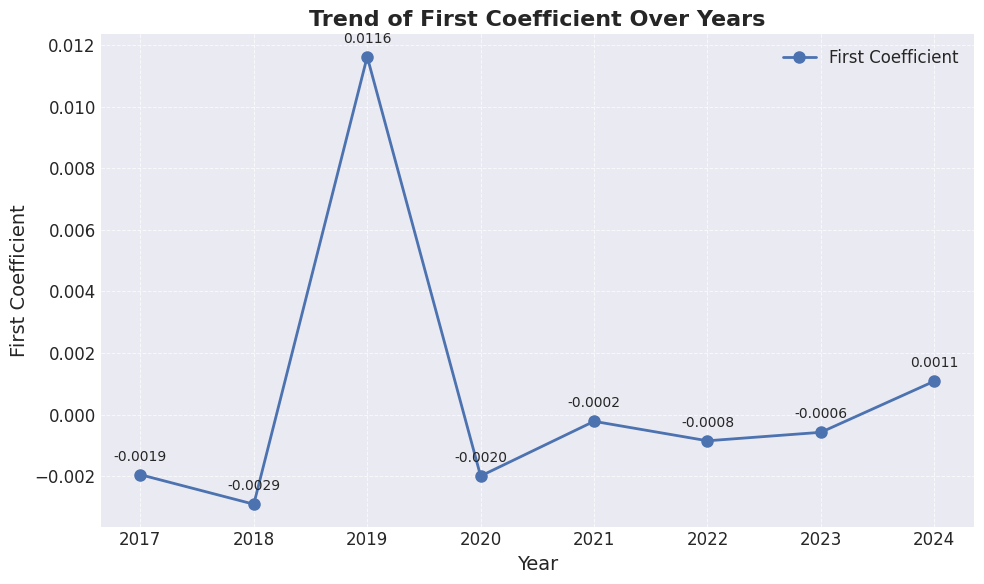

In [ ]:
def parse_coef(x):
    if isinstance(x, str):
        # Remove the square brackets and strip extra whitespace.
        x = x.strip()[1:-1]
        # Split by whitespace and convert each number to float
        if x:  # Only process non-empty strings.
            return [float(num) for num in x.split()]
        return []
    elif isinstance(x, list):
        return x
    else:
        return []

# Convert 'coef' column entries into lists of floats.
df['coef'] = df['coef'].apply(parse_coef)

# Extract the first coefficient from each list.
df['first_coef'] = df['coef'].apply(lambda x: x[0] if len(x) > 0 else None)

# Print the DataFrame to verify that the extraction worked correctly.
print(df[['coef', 'first_coef']])

# Create an advanced, polished plot.

# Use a modern matplotlib style.
plt.style.use('seaborn-darkgrid')

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the first coefficient over the years
line, = ax.plot(df["Year"], df["first_coef"], marker='o', linestyle='-',
                linewidth=2, markersize=8, label='First Coefficient')

# Annotate each data point for clarity.
for year, coef in zip(df["Year"], df["first_coef"]):
    ax.annotate(f'{coef:.4f}', xy=(year, coef), xytext=(0, 10),
                textcoords='offset points', ha='center', fontsize=10)

# Set title and axis labels.
ax.set_title('Trend of First Coefficient Over Years', fontsize=16, fontweight='bold')
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('First Coefficient', fontsize=14)

# Customize grid and legend.
ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.legend(fontsize=12)
ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.show()


   Year  first_coef  first_se  ci_lower  ci_upper
0  2017   -0.001949  0.000783 -0.003483 -0.000414
1  2018   -0.002907  0.000703 -0.004285 -0.001529
2  2019    0.011618  0.005812  0.000227  0.023009
3  2020   -0.001992  0.000379 -0.002735 -0.001250
4  2021   -0.000217  0.000043 -0.000302 -0.000132
5  2022   -0.000849  0.000191 -0.001223 -0.000475
6  2023   -0.000573  0.000163 -0.000893 -0.000254
7  2024    0.001086  0.000391  0.000319  0.001853


<ipython-input-260-36c8454ac115>:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')  # White style without grid lines.


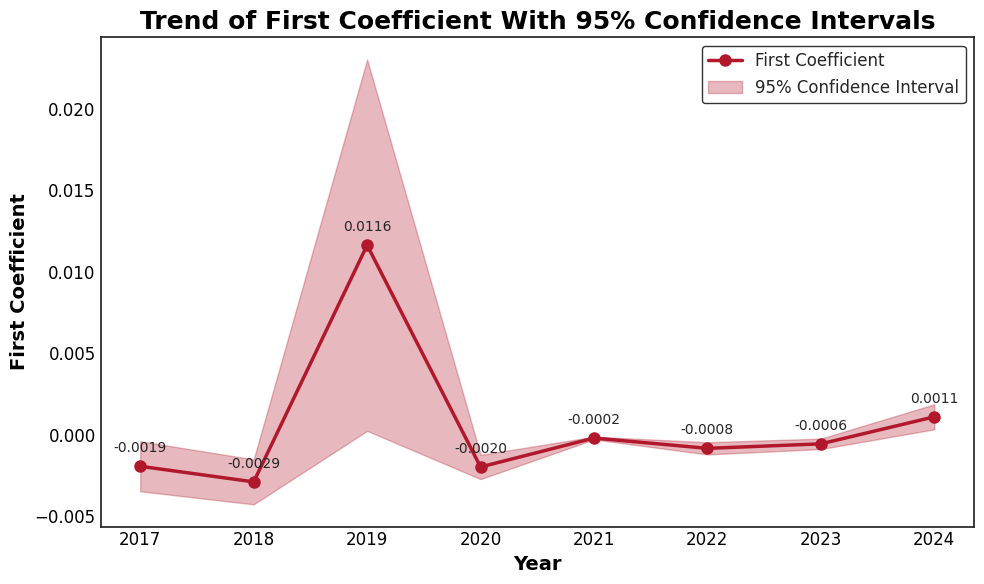

In [ ]:
def parse_list_from_string(x):
    if isinstance(x, list):
        return x
    elif isinstance(x, str):
        s = x.strip().replace('[','').replace(']','')
        return [float(num) for num in s.split()]
    else:
        return []

# Apply the parsing function to both the 'coef' and 'se' columns.
df['coef'] = df['coef'].apply(parse_list_from_string)
df['se'] = df['se'].apply(parse_list_from_string)

# Extract the first coefficient and its standard error.
df['first_coef'] = df['coef'].apply(lambda x: x[0] if len(x) > 0 else None)
df['first_se'] = df['se'].apply(lambda x: x[0] if len(x) > 0 else None)

# Compute 95% confidence intervals using a z-score of 1.96.
z = 1.96
df['ci_lower'] = df['first_coef'] - z * df['first_se']
df['ci_upper'] = df['first_coef'] + z * df['first_se']

# (Optional) Print to verify values.
print(df[['Year', 'first_coef', 'first_se', 'ci_lower', 'ci_upper']])

# Plotting: Use a white background with no grid lines.
plt.style.use('seaborn-white')  # White style without grid lines.
fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')

# Choose a shade from the 'RdGy' colormap.
cmap = plt.get_cmap('RdGy')
line_color = cmap(0.1)  # Adjust intensity as desired.

# Plot the first coefficient as a line with markers.
ax.plot(df['Year'], df['first_coef'], marker='o', linestyle='-', linewidth=2.5,
        markersize=8, color=line_color, label='First Coefficient')

# Plot the 95% confidence intervals with a semi-transparent fill.
ax.fill_between(df['Year'], df['ci_lower'], df['ci_upper'], color=line_color, alpha=0.3,
                label='95% Confidence Interval')

# Annotate each data point.
for i, row in df.iterrows():
    ax.annotate(f"{row['first_coef']:.4f}", (row['Year'], row['first_coef']),
                textcoords="offset points", xytext=(0, 10),
                ha='center', fontsize=10)

# Set title and axis labels with custom styling.
ax.set_title("Trend of First Coefficient With 95% Confidence Intervals",
             fontsize=18, fontweight='bold', color='black')
ax.set_xlabel("Year", fontsize=14, fontweight='bold', color='black')
ax.set_ylabel("First Coefficient", fontsize=14, fontweight='bold', color='black')

# Disable any grid lines.
ax.grid(False)

# Customize tick parameters.
ax.tick_params(axis='both', which='major', labelsize=12, colors='black')

# Add a legend.
ax.legend(fontsize=12, frameon=True, facecolor='white', edgecolor='black')

plt.tight_layout()
plt.show()

   Year  first_coef  first_se  ci_lower  ci_upper
0  2017   -0.001949  0.000783 -0.003483 -0.000414
1  2018   -0.002907  0.000703 -0.004285 -0.001529
2  2019    0.011618  0.005812  0.000227  0.023009
3  2020   -0.001992  0.000379 -0.002735 -0.001250
4  2021   -0.000217  0.000043 -0.000302 -0.000132
5  2022   -0.000849  0.000191 -0.001223 -0.000475
6  2023   -0.000573  0.000163 -0.000893 -0.000254
7  2024    0.001086  0.000391  0.000319  0.001853


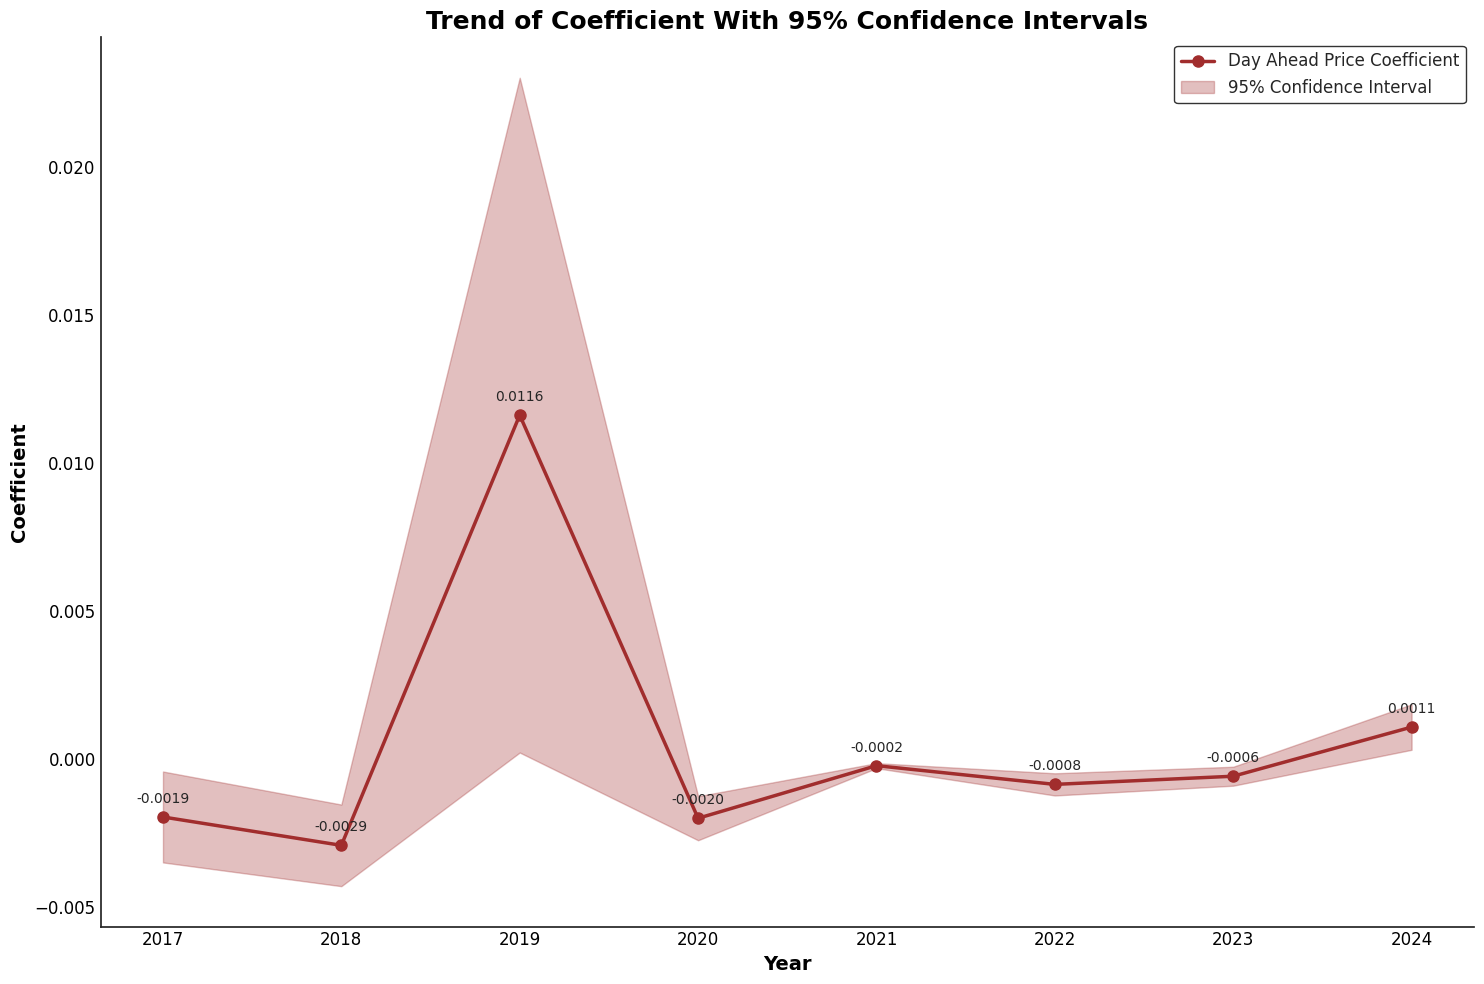

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data parsing and preparation ---
def parse_list_from_string(x):
    if isinstance(x, list):
        return x
    elif isinstance(x, str):
        s = x.strip().replace('[', '').replace(']', '')
        return [float(num) for num in s.split()]
    else:
        return []

# Apply the parsing function to both the 'coef' and 'se' columns.
df['coef'] = df['coef'].apply(parse_list_from_string)
df['se'] = df['se'].apply(parse_list_from_string)

# Extract the first coefficient and its standard error.
df['first_coef'] = df['coef'].apply(lambda x: x[0] if len(x) > 0 else None)
df['first_se'] = df['se'].apply(lambda x: x[0] if len(x) > 0 else None)

# Compute 95% confidence intervals using a z-score of 1.96.
z = 1.96
df['ci_lower'] = df['first_coef'] - z * df['first_se']
df['ci_upper'] = df['first_coef'] + z * df['first_se']

# Optional: Print to verify values.
print(df[['Year', 'first_coef', 'first_se', 'ci_lower', 'ci_upper']])

# --- Plotting ---
# Set the style to a white background.
sns.set_style("white")

# Create the figure and axis with a 15×10 inches size and white background.
fig, ax = plt.subplots(figsize=(15, 10), facecolor='white')

# Choose a color from the RdGy colormap.
cmap = plt.get_cmap('RdGy')
line_color = '#a12d2d'

# Plot the first coefficient as a line with markers.
ax.plot(df['Year'], df['first_coef'], marker='o', linestyle='-', linewidth=2.5,
        markersize=8, color=line_color, label='Day Ahead Price Coefficient')

# Plot the 95% confidence intervals with a semi-transparent fill.
ax.fill_between(df['Year'], df['ci_lower'], df['ci_upper'], color=line_color, alpha=0.3,
                label='95% Confidence Interval')


# Annotate each data point.
for i, row in df.iterrows():
    ax.annotate(f"{row['first_coef']:.4f}", (row['Year'], row['first_coef']),
                textcoords="offset points", xytext=(0, 10),
                ha='center', fontsize=10)

# Set title and axis labels with custom styling.
ax.set_title("Trend of Coefficient With 95% Confidence Intervals",
             fontsize=18, fontweight='bold', color='black')
ax.set_xlabel("Year", fontsize=14, fontweight='bold', color='black')
ax.set_ylabel("Coefficient", fontsize=14, fontweight='bold', color='black')

# Customize tick parameters.
ax.tick_params(axis='both', which='major', labelsize=12, colors='black')

# Remove top and right spines for a cleaner look.
sns.despine(top=True, right=True, left=False, bottom=False)

# Add a legend with a styled frame.
ax.legend(fontsize=12, frameon=True, facecolor='white', edgecolor='black')

plt.tight_layout()
plt.show()


In [ ]:
def evaluate_predictions_country(predictions, true_values, target_name="TargetVariable", country_values=None, title="Country"):
    """
    Evaluate model predictions against true values with metrics and visualizations.

    Args:
        predictions (pd.Series or np.ndarray): Model's predicted values.
        true_values (pd.Series or np.ndarray): True values from the dataset.
        target_name (str): Name of the target variable (for labeling plots and messages).
        country_values (pd.Series or np.ndarray): Country values corresponding to the data for coloring.

    Returns:
        dict: Dictionary of metrics including MAE, RMSE, R², and percentage errors.
    """
    import seaborn as sns
    from matplotlib.colors import ListedColormap

    # Ensure inputs are aligned
    if isinstance(predictions, np.ndarray):
        predictions = pd.Series(predictions, index=true_values.index)

    # Calculate metrics
    metrics = calculate_metrics(true_values, predictions)

    # Print metrics
    print_metrics(metrics, dataset_type=f"Test - {target_name}")

    # Target range for error normalization
    target_min = true_values.min()
    target_max = true_values.max()
    target_range = target_max - target_min
    print(f"{target_name} Range: Min = {target_min}, Max = {target_max}, Range = {target_range}")

    # Percentage error metrics
    mae_percentage = (metrics['MAE'] / target_range) * 100
    rmse_percentage = (metrics['RMSE'] / target_range) * 100

    print(f"MAE as percentage of range: {mae_percentage:.2f}%")
    print(f"RMSE as percentage of range: {rmse_percentage:.2f}%")

    # Apply RdGy color palette for countries
    if country_values is not None:
        unique_countries = np.unique(country_values)
        num_countries = len(unique_countries)

        # Use RdGy color palette
        colors = sns.color_palette("RdGy", num_countries)
        color_mapping = {country: colors[idx] for idx, country in enumerate(unique_countries)}
        dot_colors = [color_mapping[country] for country in country_values]
    else:
        dot_colors = 'blue'
        color_mapping = None

    # --- Plot: Predicted vs Actual ---
    plt.figure(figsize=(10, 6))
    plt.scatter(true_values, predictions, c=dot_colors, alpha=0.7, edgecolors='k', linewidth=0.4)
    plt.plot([target_min, target_max], [target_min, target_max], 'r--', label='Perfect prediction')
    plt.title(f'Predicted vs. Actual {target_name}')
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel(f'Predicted {target_name}')
    if country_values is not None:
        handles = [
            plt.Line2D([0], [0], marker='o', color=color_mapping[country], linestyle='', label=country)
            for country in unique_countries
        ]
        plt.legend(handles=handles, title=title, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.figure(figsize=(10, 6), constrained_layout=True)
    plt.show()

    # --- Plot: Residuals ---
    plt.figure(figsize=(10, 6))
    residuals = true_values - predictions
    plt.scatter(true_values, residuals, c=dot_colors, alpha=0.7, edgecolors='k', linewidth=0.4)
    plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
    plt.title(f'Residuals vs. Actual {target_name}')
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel('Residuals')
    if country_values is not None:
        plt.legend(handles=handles, title=title, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    # Return metrics
    return {
        "Metrics": metrics,
        "MAE_Percentage": mae_percentage,
        "RMSE_Percentage": rmse_percentage
    }


In [ ]:
df_perfect = pd.read_csv('filtered_data_2lags_tretm_dem_price.csv')

In [ ]:
result = evaluate_predictions_country(
    predictions=df_perfect["Prrediction"],
    true_values=df_perfect["consumption_normalized"],
    target_name="consumption_normalized",
    country_values=df_perfect["Country"]
)

Test - consumption_normalized Metrics:
  MAE: 0.1871
  RMSE: 0.2317
  R²: -0.4262
consumption_normalized Range: Min = 0.0, Max = 2.749327903946239, Range = 2.749327903946239
MAE as percentage of range: 6.81%
RMSE as percentage of range: 8.43%


In [ ]:
result["Pred_vs_Actual_Fig"].savefig("predicted_vs_actual1.png", dpi=300)
result["Residuals_Fig"].savefig("residuals_vs_actual1.png", dpi=300)

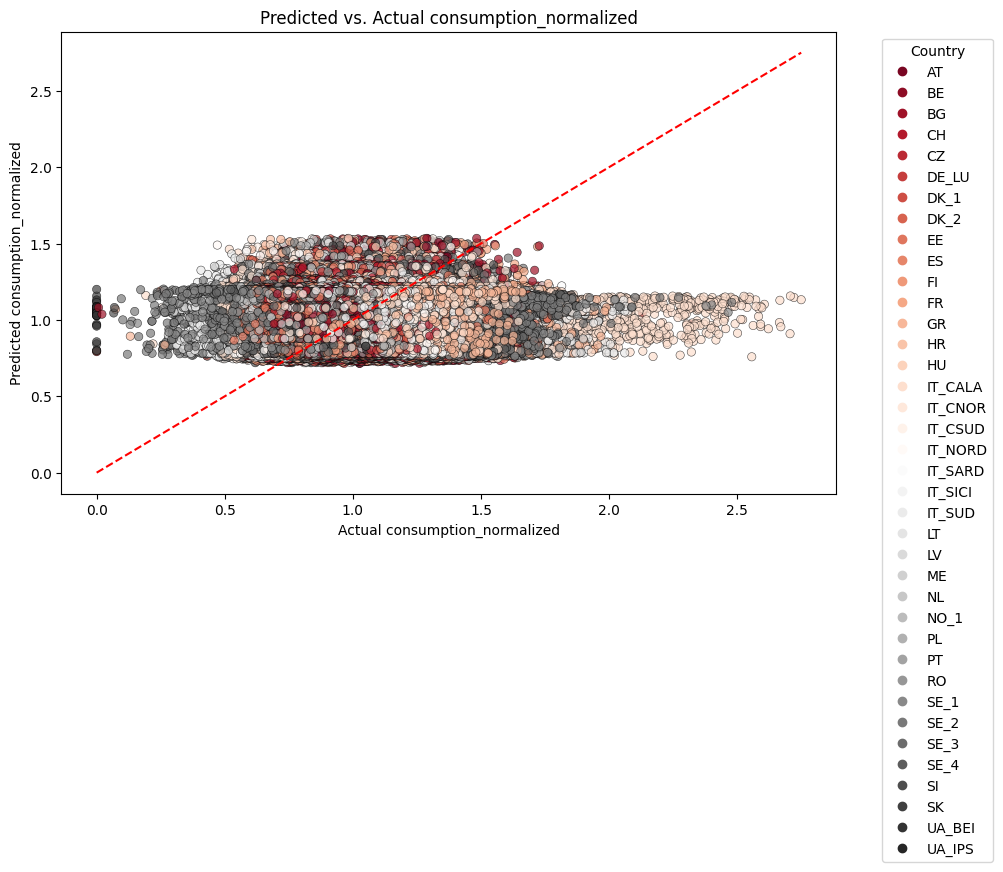

In [ ]:
result["Pred_vs_Actual_Fig"]

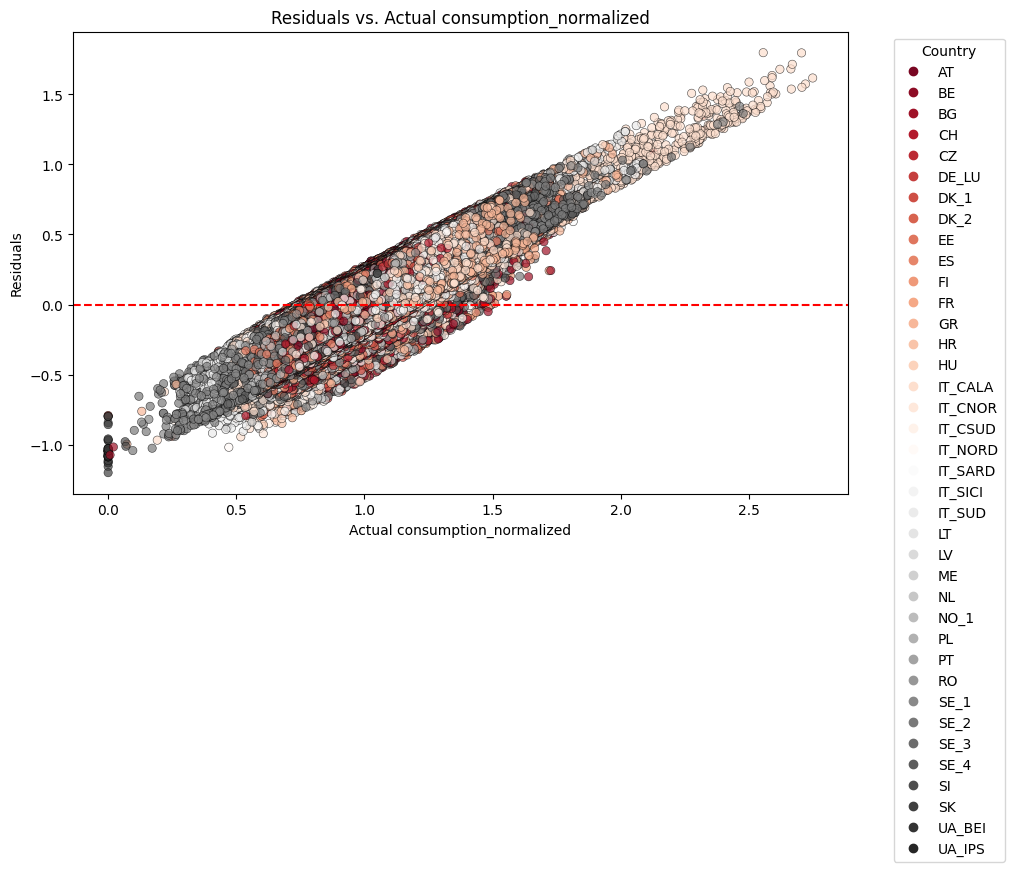

In [ ]:
result["Residuals_Fig"]

In [ ]:
df_perfect_1 = pd.read_csv("lag_consumtion_df.csv")
df_perfect_1

,Unnamed: 0,Time,ConsumptionValue,DayAheadPriceEUR,WeatherWindSpeed,WeatherTemperature,Year,Day,Hour,WeatherTemperature_F,...,block_4.0:Solar_MWh,block_5.0:tempbin,block_5.0:tempbin2,block_5.0:Solar_MWh,block_6.0:tempbin,block_6.0:tempbin2,block_6.0:Solar_MWh,Lag1_Consumption,Prrediction,Residuals
0,NaN,2017-01-01 00:00:00,47597.00,18.1300,6.112134,270.016953,2017,1.0,24.0,26.360515,...,0.0,0.0,0.0,0.0,1.0,0.694877,0.0,0.850489,0.847083,0.031291
1,649157.0,2017-01-01 00:00:00,6728.00,25.0000,3.642289,272.530090,2017,1.0,24.0,30.884163,...,0.0,0.0,0.0,0.0,2.0,0.953831,0.0,0.974300,0.924399,-0.003298
2,649193.0,2017-01-01 01:00:00,1114.00,18.1300,13.791865,278.552094,2017,1.0,1.0,41.723768,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.817939,0.811925,0.063880
3,649181.0,2017-01-01 01:00:00,4875.00,51.9500,5.243385,278.840179,2017,1.0,1.0,42.242323,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.945237,0.907895,0.047400
4,649182.0,2017-01-01 01:00:00,5964.00,44.4268,5.953310,268.244995,2017,1.0,1.0,23.170991,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.959327,0.963934,0.094078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1963235,NaN,2024-12-31 23:00:00,10729.50,4.8500,5.314154,265.901459,2024,31.0,23.0,18.952626,...,0.0,0.0,0.0,0.0,1.0,0.359202,0.0,1.181192,1.151948,0.002207
1963236,NaN,2024-12-31 23:00:00,4545.00,138.7000,3.535453,283.701355,2024,31.0,23.0,50.992439,...,0.0,0.0,0.0,0.0,4.0,2.600229,0.0,0.835920,0.785692,-0.005490
1963237,NaN,2024-12-31 23:00:00,1971.50,125.3100,2.739260,277.086395,2024,31.0,23.0,39.085511,...,0.0,0.0,0.0,0.0,2.0,1.527677,0.0,1.011109,0.949773,0.002789
1963238,NaN,2024-12-31 23:00:00,5002.25,147.2500,2.887089,269.677643,2024,31.0,23.0,25.749757,...,0.0,0.0,0.0,0.0,1.0,0.663050,0.0,1.061121,1.038075,0.024906


In [ ]:
result = evaluate_predictions_country(
    predictions=df_perfect_1["Prrediction"],
    true_values=df_perfect_1["consumption_normalized"],
    target_name="consumption_normalized",
    country_values=df_perfect_1["Country"]
)

Test - consumption_normalized Metrics:
  MAE: 0.0273
  RMSE: 0.0378
  R²: 0.9615
consumption_normalized Range: Min = 0.0, Max = 2.4783060241355925, Range = 2.4783060241355925
MAE as percentage of range: 1.10%
RMSE as percentage of range: 1.53%


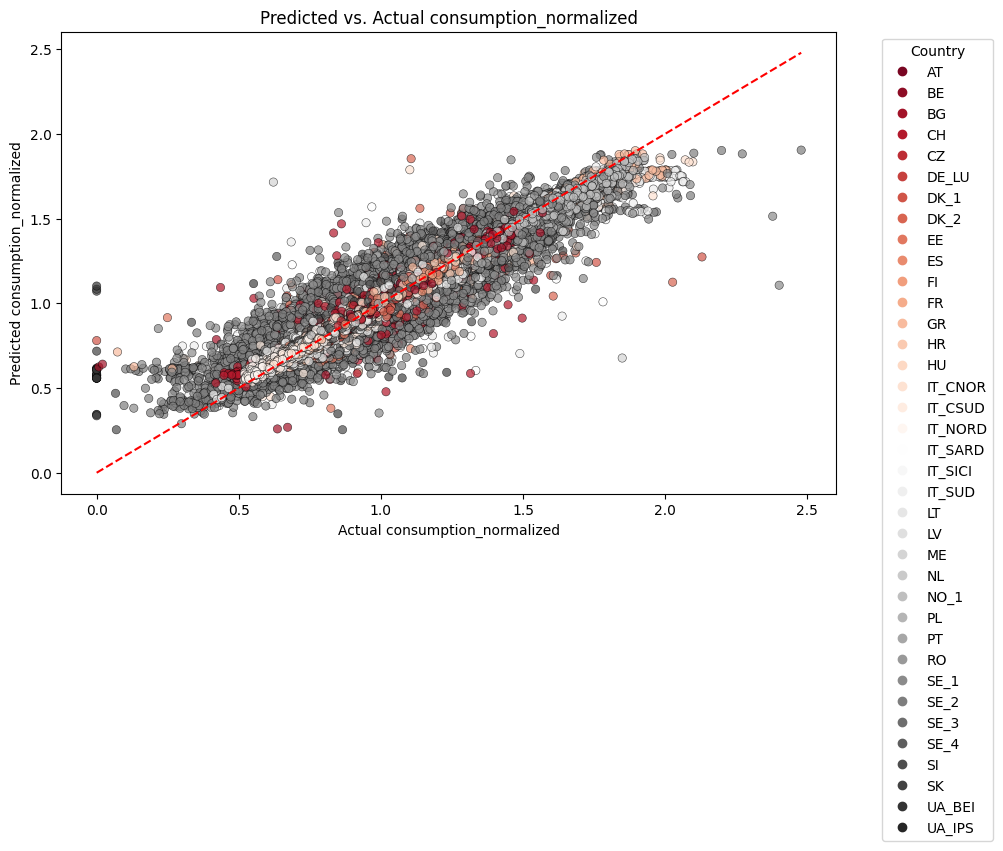

In [ ]:
result["Pred_vs_Actual_Fig"]

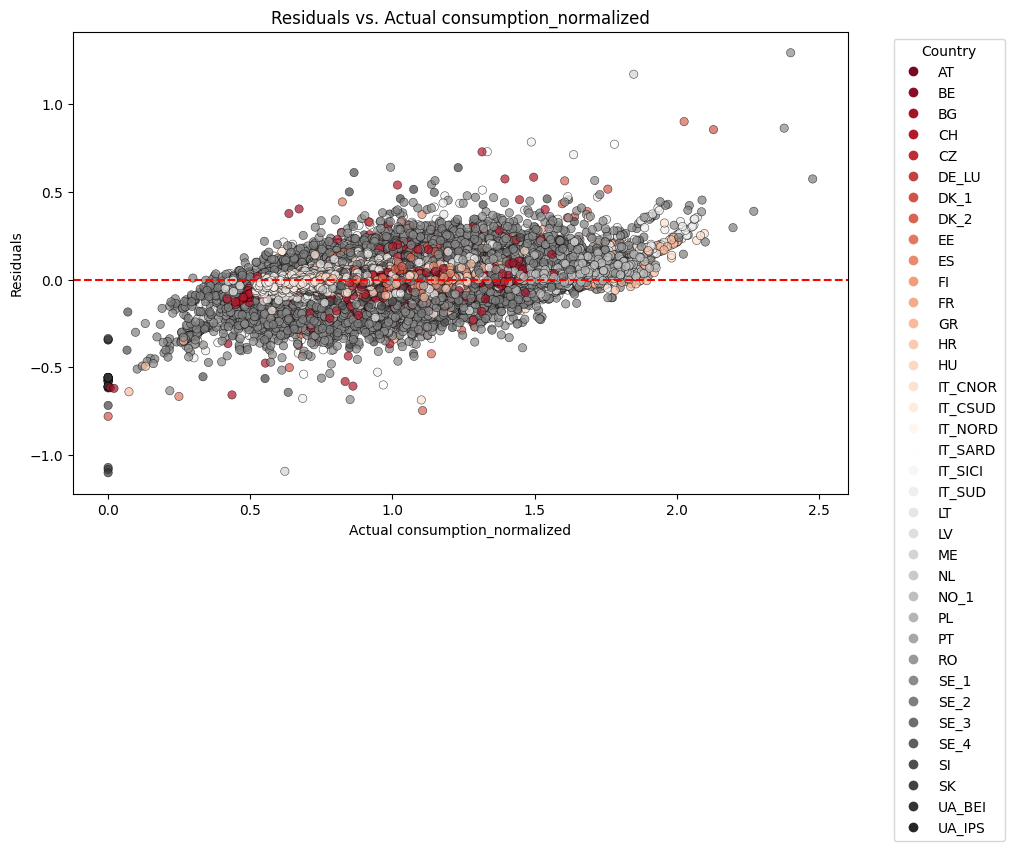

In [ ]:
result["Residuals_Fig"]

In [ ]:
result["Pred_vs_Actual_Fig"].savefig("predicted_vs_actual.png", dpi=300)
result["Residuals_Fig"].savefig("residuals_vs_actual.png", dpi=300)

#Importance

In [ ]:
importance = pd.read_csv("importance_df_2lags_tretm_dem_price.csv")

In [ ]:
importance

,Feature,Mean Importance,Std Importance
0,block_6.0:tempbin2,0.071537,0.003957
1,block_1.0:tempbin,0.066121,0.015904
2,block_1.0:tempbin2,0.065019,0.005389
3,block_6.0:tempbin,0.055789,0.016952
4,Month_1,0.030854,0.008175
...,...,...,...
234,HourOfWeek_61,0.000000,0.000000
235,HourOfWeek_72,0.000000,0.000000
236,HourOfWeek_115,0.000000,0.000000
237,HourOfWeek_16,0.000000,0.000000


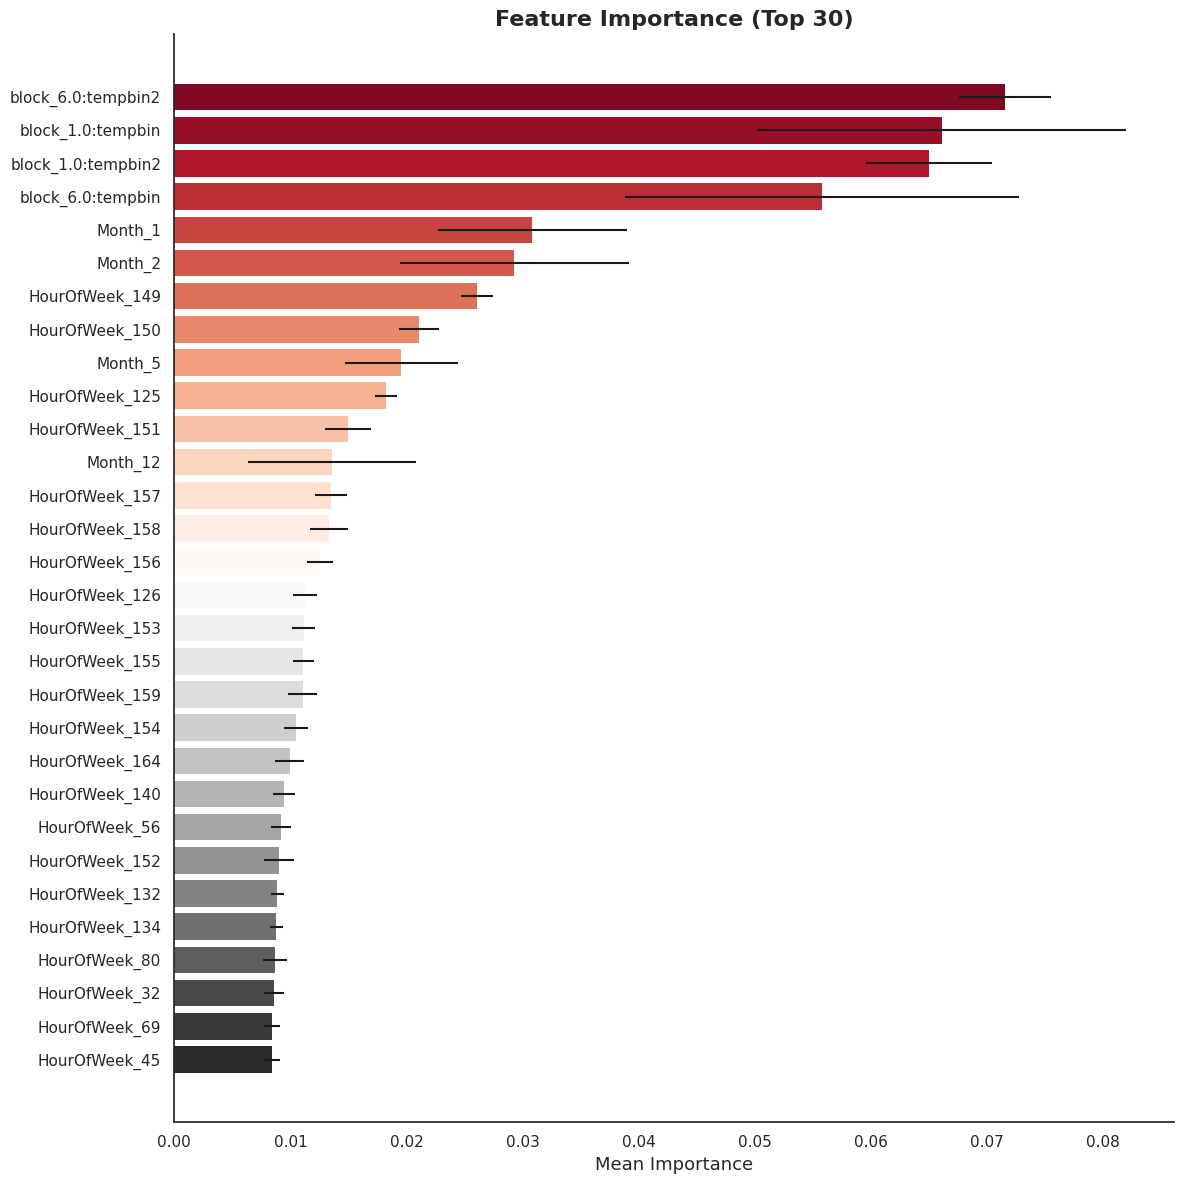

In [ ]:
top50 = importance.sort_values(by='Mean Importance', ascending=False).head(30)
feat_importance = top50.sort_values(by='Mean Importance', ascending=True).reset_index(drop=True)

# Set clean style with no background grid
sns.set(style="white")

# Create a reversed RdGy color palette
colors = sns.color_palette("RdGy", len(feat_importance))[::-1]

# Create explicit y-axis positions for each bar.
y_positions = list(range(len(feat_importance)))

# Plot with a specified figure size.
plt.figure(figsize=(12, 12))  # Increase vertical space if needed
bar_height = 0.8  # Adjust this value to control spacing between bars

plt.barh(
    y_positions,
    feat_importance['Mean Importance'],
    xerr=feat_importance['Std Importance'],  # Show error bars if desired
    color=colors,
    edgecolor='none',
    height=bar_height
)

# Set y-ticks and labels based on the explicit positions.
plt.yticks(y_positions, feat_importance['Feature'], fontsize=11)

# Styling
plt.title('Feature Importance (Top 30)', fontsize=16, weight='bold')
plt.xlabel('Mean Importance', fontsize=13)
plt.xticks(fontsize=11)

# Remove top and right spines; keep bottom and left.
sns.despine(top=True, right=True, left=False, bottom=False)

# Remove grid lines.
plt.grid(False)

# Save and show the plot.
plt.tight_layout()
plt.savefig("feature_importance_with_axes_lines.png", dpi=300)
plt.show()


In [ ]:
lag_importance = pd.read_csv("second_model_lags_importance_df_importance.csv")
lag_importance

,Feature,Mean Importance,Std Importance
0,block_6.0:tempbin,0.083044,0.011327
1,block_1.0:tempbin2,0.065429,0.007066
2,block_6.0:tempbin2,0.063508,0.005521
3,block_1.0:tempbin,0.062392,0.014446
4,Month_2,0.030156,0.008967
...,...,...,...
145,Total_Wind_Generation_lag32,0.000393,0.000110
146,Total_Wind_Generation_lag22,0.000369,0.000190
147,Total_Wind_Generation_lag6,0.000314,0.000106
148,Total_Wind_Generation_lag20,0.000286,0.000150


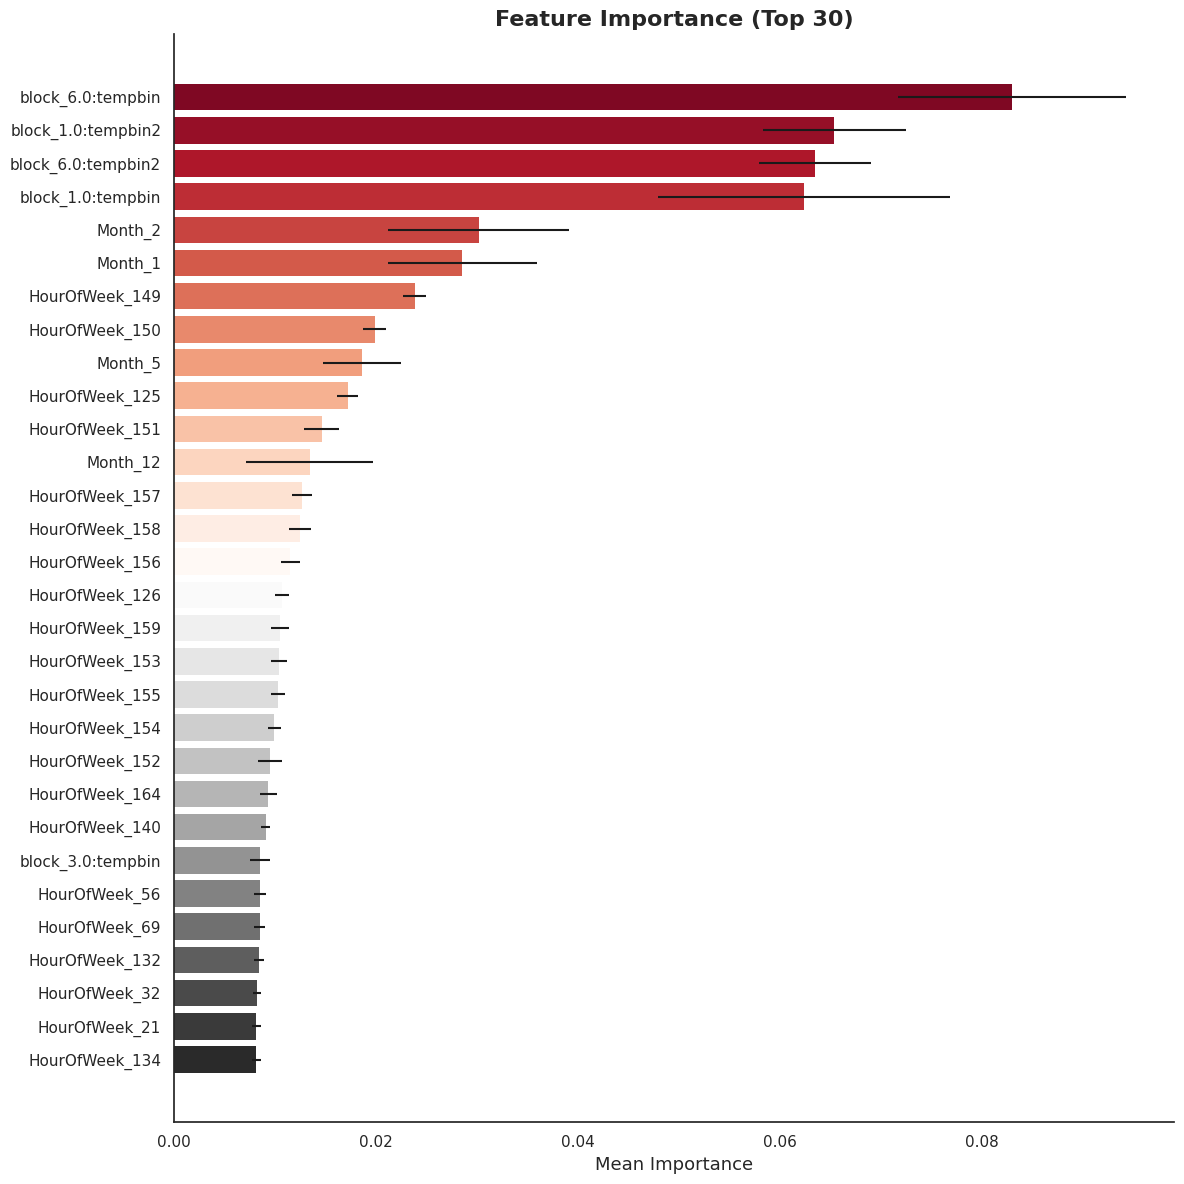

In [ ]:
# Select the top 50 features by descending mean importance,
# then sort those top 50 in ascending order for the horizontal bar chart.
top50 = lag_importance.sort_values(by='Mean Importance', ascending=False).head(30)
feat_importance = top50.sort_values(by='Mean Importance', ascending=True).reset_index(drop=True)

# Set clean style with no background grid
sns.set(style="white")

# Create a reversed RdGy color palette
colors = sns.color_palette("RdGy", len(feat_importance))[::-1]

# Create explicit y-axis positions for each bar.
y_positions = list(range(len(feat_importance)))

# Plot with a specified figure size.
plt.figure(figsize=(12, 12))  # Increase vertical space if needed
bar_height = 0.8  # Adjust this value to control spacing between bars

plt.barh(
    y_positions,
    feat_importance['Mean Importance'],
    xerr=feat_importance['Std Importance'],  # Show error bars if desired
    color=colors,
    edgecolor='none',
    height=bar_height
)

# Set y-ticks and labels based on the explicit positions.
plt.yticks(y_positions, feat_importance['Feature'], fontsize=11)

# Styling
plt.title('Feature Importance (Top 30)', fontsize=16, weight='bold')
plt.xlabel('Mean Importance', fontsize=13)
plt.xticks(fontsize=11)

# Remove top and right spines; keep bottom and left.
sns.despine(top=True, right=True, left=False, bottom=False)

# Remove grid lines.
plt.grid(False)

# Save and show the plot.
plt.tight_layout()
plt.savefig("feature_importance_with_axes_lines.png", dpi=300)
plt.show()

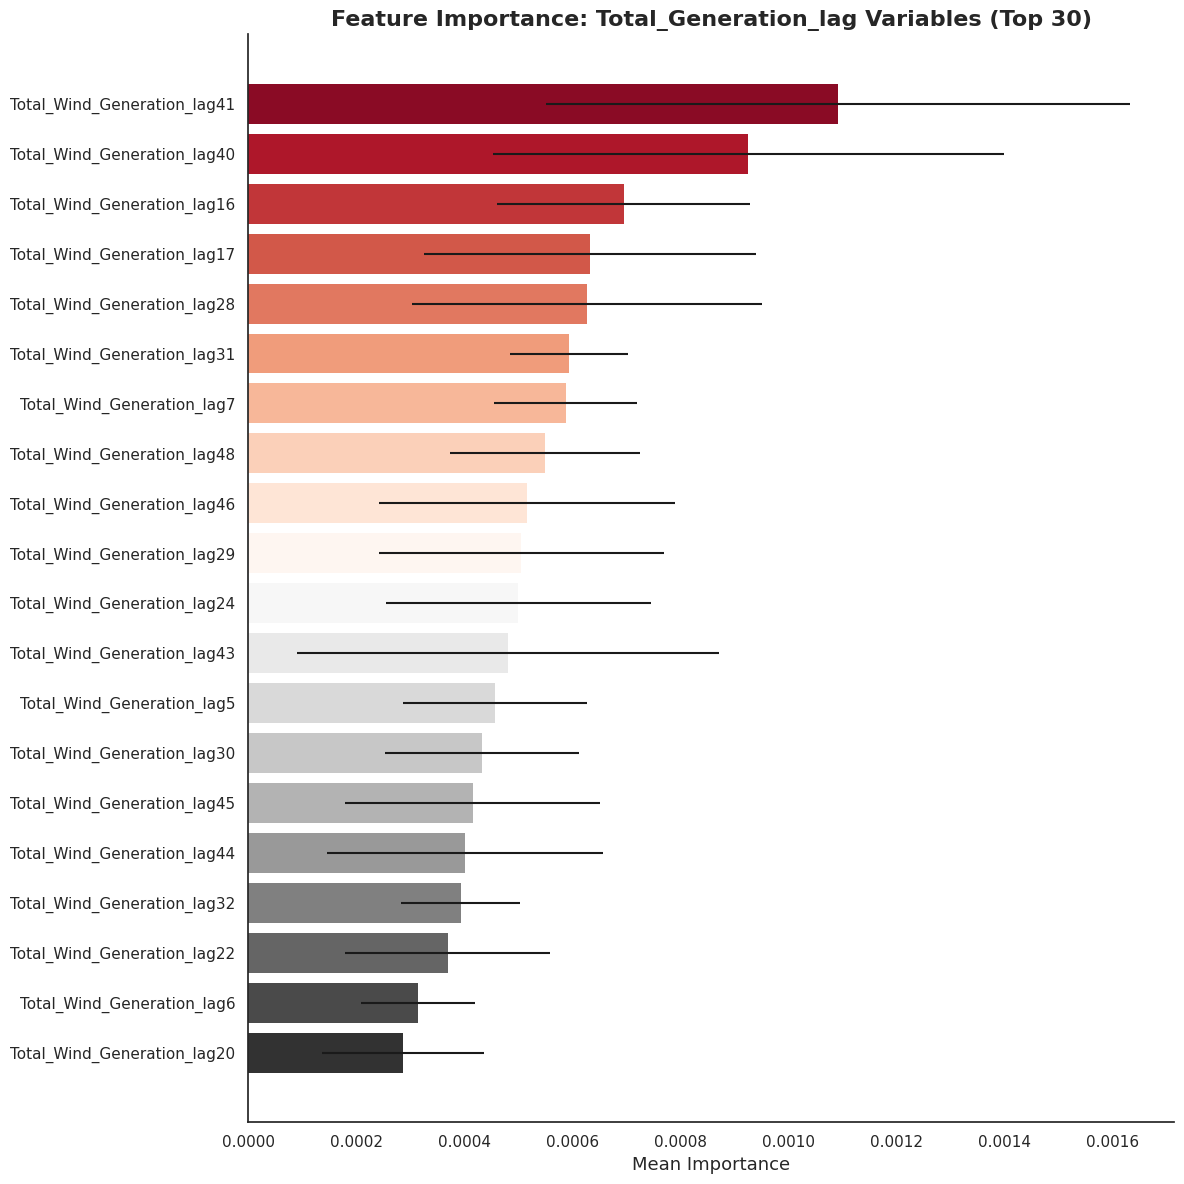

In [ ]:
filtered = lag_importance[lag_importance['Feature'].str.startswith("Total_Wind_Generation_lag")]

# Step 2: Select the top 30 features by descending Mean Importance, then sort them in ascending order
top30 = filtered.sort_values(by='Mean Importance', ascending=False).head(30)
feat_importance = top30.sort_values(by='Mean Importance', ascending=True).reset_index(drop=True)

# Set clean style with no background grid
sns.set(style="white")

# Create a reversed RdGy color palette
colors = sns.color_palette("RdGy", len(feat_importance))[::-1]

# Create explicit y-axis positions for each bar.
y_positions = list(range(len(feat_importance)))

# Plot with a specified figure size.
plt.figure(figsize=(12, 12))  # Increase vertical space if needed
bar_height = 0.8  # Adjust this value to control spacing between bars

plt.barh(
    y_positions,
    feat_importance['Mean Importance'],
    xerr=feat_importance['Std Importance'],  # Show error bars if desired
    color=colors,
    edgecolor='none',
    height=bar_height
)

# Set y-ticks and labels based on the explicit positions.
plt.yticks(y_positions, feat_importance['Feature'], fontsize=11)

# Styling the plot.
plt.title('Feature Importance: Total_Generation_lag Variables (Top 30)', fontsize=16, weight='bold')
plt.xlabel('Mean Importance', fontsize=13)
plt.xticks(fontsize=11)

# Remove top and right spines; keep bottom and left.
sns.despine(top=True, right=True, left=False, bottom=False)

# Remove any grid lines.
plt.grid(False)

# Save and show the plot.
plt.tight_layout()
plt.savefig("Total_Generation_lag_feature_importance.png", dpi=300)
plt.show()


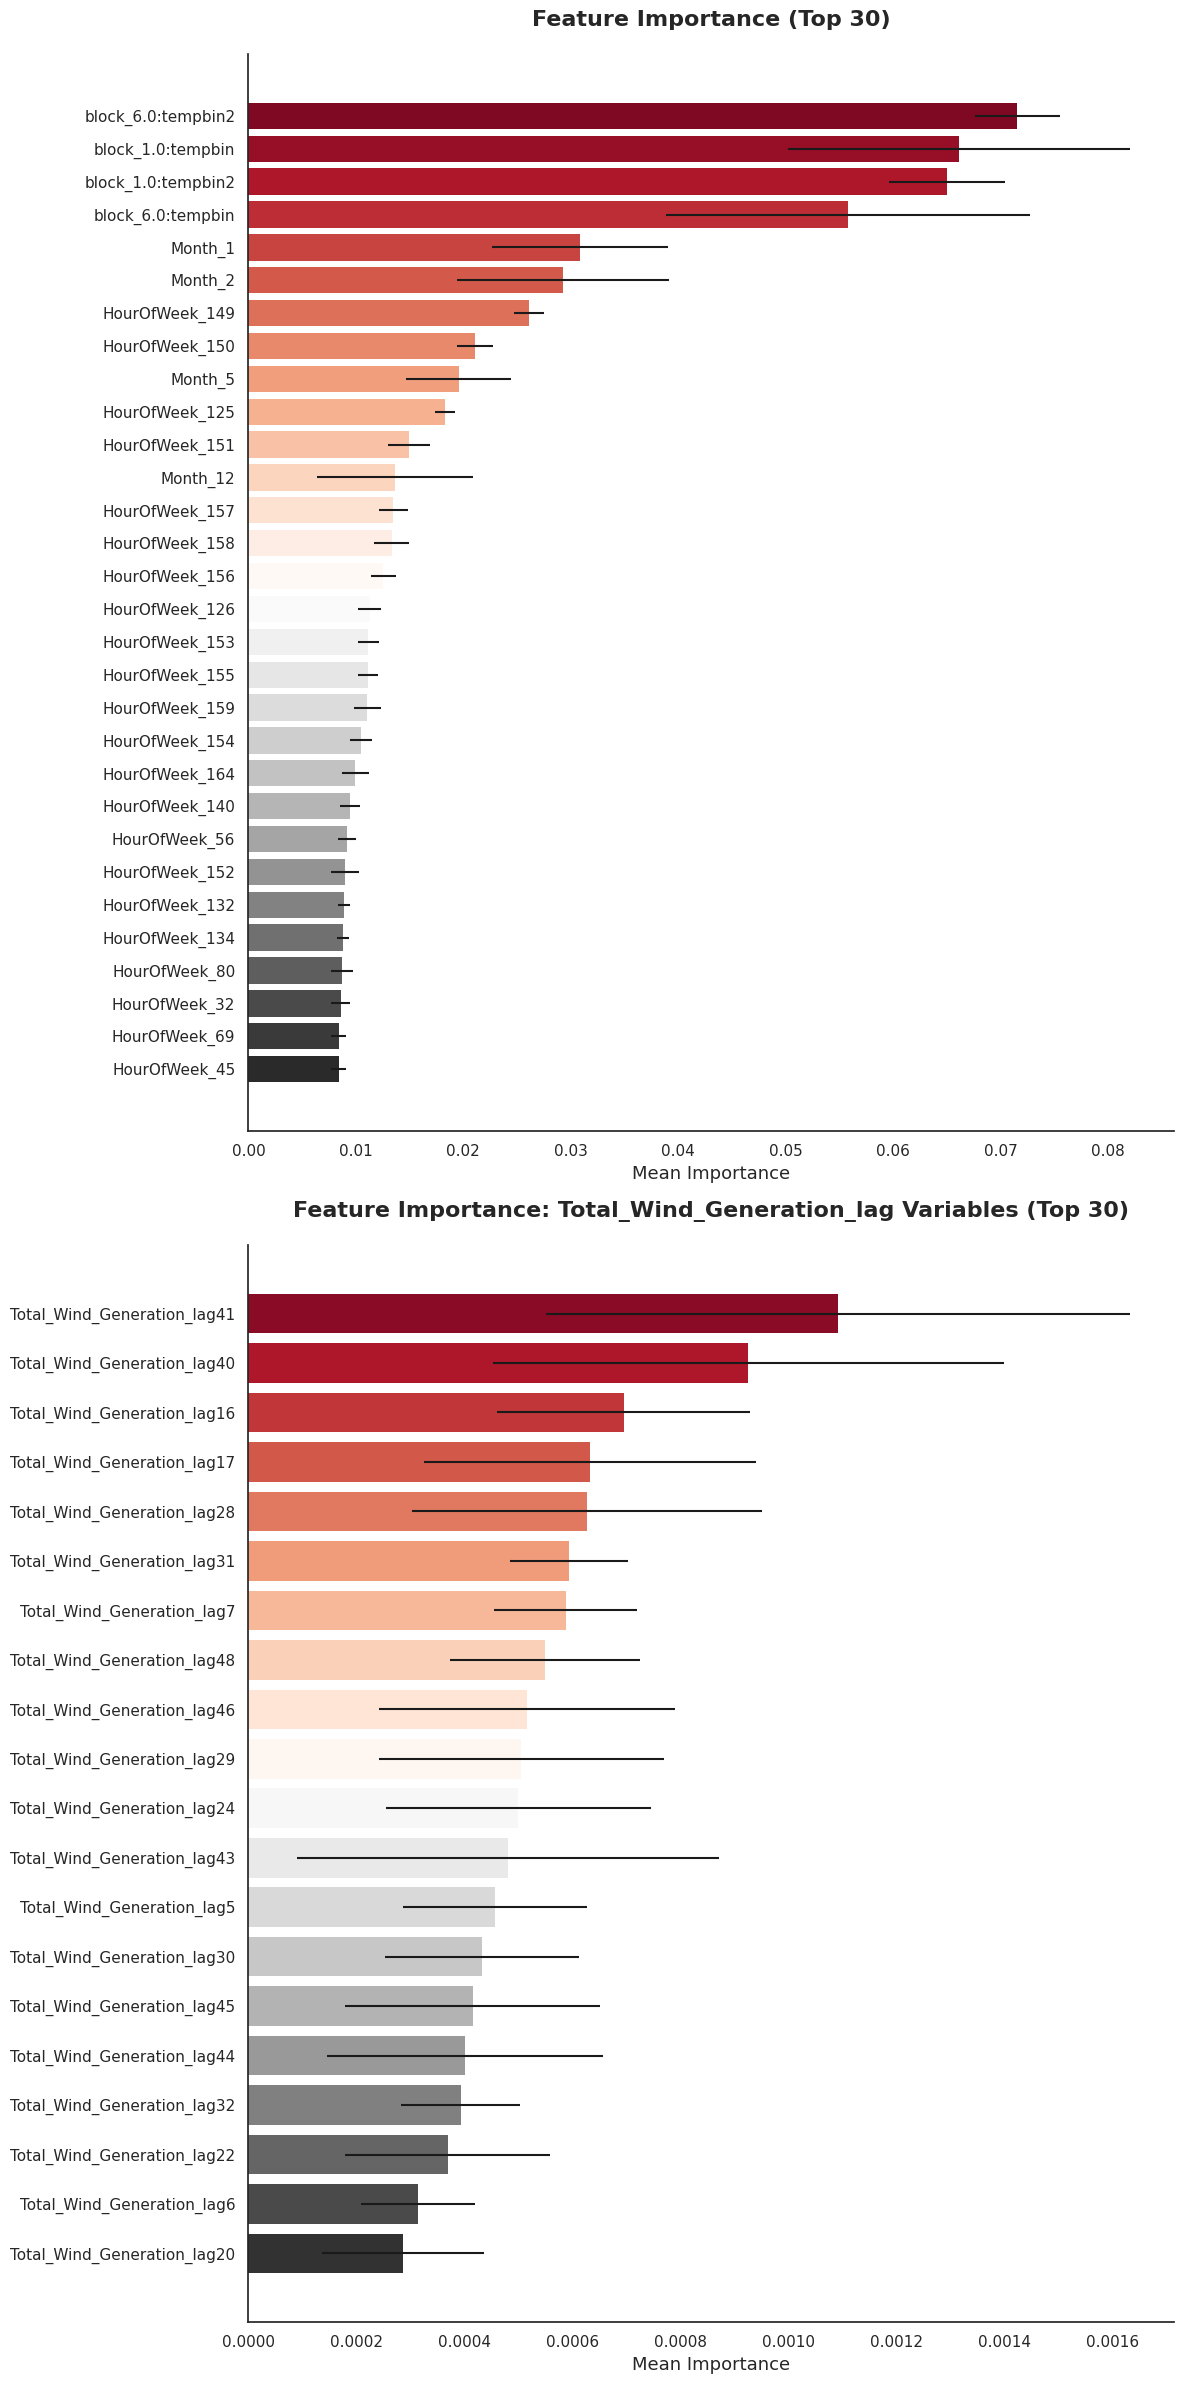

In [ ]:
top30_overall = importance.sort_values(by='Mean Importance', ascending=False).head(30)
feat_importance_overall = top30_overall.sort_values(by='Mean Importance', ascending=True).reset_index(drop=True)

# Create a reversed RdGy color palette for overall plot
colors_overall = sns.color_palette("RdGy", len(feat_importance_overall))[::-1]
y_positions_overall = list(range(len(feat_importance_overall)))

# -----------------------------
# Data preparation for Plot 2: Total_Wind_Generation_lag Variables (Top 30)
# Assume your DataFrame 'lag_importance' is already loaded with columns:
# ["Feature", "Mean Importance", "Std Importance"]

# Filter rows that start with "Total_Wind_Generation_lag"
filtered = lag_importance[lag_importance['Feature'].str.startswith("Total_Wind_Generation_lag")]

# Select the top 30 features by descending Mean Importance, then sort in ascending order
top30_lag = filtered.sort_values(by='Mean Importance', ascending=False).head(30)
feat_importance_lag = top30_lag.sort_values(by='Mean Importance', ascending=True).reset_index(drop=True)

# Create a reversed RdGy color palette for the lag features plot
colors_lag = sns.color_palette("RdGy", len(feat_importance_lag))[::-1]
y_positions_lag = list(range(len(feat_importance_lag)))

# -----------------------------
# Plotting: Create a combined figure with 2 vertical subplots

# Use seaborn white style for a clean background (no grid)
sns.set(style="white")

# Create subplots: 2 rows, 1 column.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 24))

# Define common bar height (adjust to increase space between bars)
bar_height = 0.8

# --- Plot 1: Overall Top 30 Features ---
ax1.barh(
    y_positions_overall,
    feat_importance_overall['Mean Importance'],
    xerr=feat_importance_overall['Std Importance'],  # Optional error bars
    color=colors_overall,
    edgecolor='none',
    height=bar_height
)
ax1.set_yticks(y_positions_overall)
ax1.set_yticklabels(feat_importance_overall['Feature'], fontsize=11)
ax1.set_title('Feature Importance (Top 30)', fontsize=16, weight='bold', pad=20)
ax1.set_xlabel('Mean Importance', fontsize=13)
ax1.tick_params(axis='x', labelsize=11)
sns.despine(ax=ax1, top=True, right=True, left=False, bottom=False)
ax1.grid(False)

# --- Plot 2: Total_Wind_Generation_lag Variables (Top 30) ---
ax2.barh(
    y_positions_lag,
    feat_importance_lag['Mean Importance'],
    xerr=feat_importance_lag['Std Importance'],  # Optional error bars
    color=colors_lag,
    edgecolor='none',
    height=bar_height
)
ax2.set_yticks(y_positions_lag)
ax2.set_yticklabels(feat_importance_lag['Feature'], fontsize=11)
ax2.set_title('Feature Importance: Total_Wind_Generation_lag Variables (Top 30)', fontsize=16, weight='bold', pad=20)
ax2.set_xlabel('Mean Importance', fontsize=13)
ax2.tick_params(axis='x', labelsize=11)
sns.despine(ax=ax2, top=True, right=True, left=False, bottom=False)
ax2.grid(False)

# Adjust layout, save, and show the combined plot.
plt.tight_layout()
plt.savefig("combined_feature_importance.png", dpi=300)
plt.show()


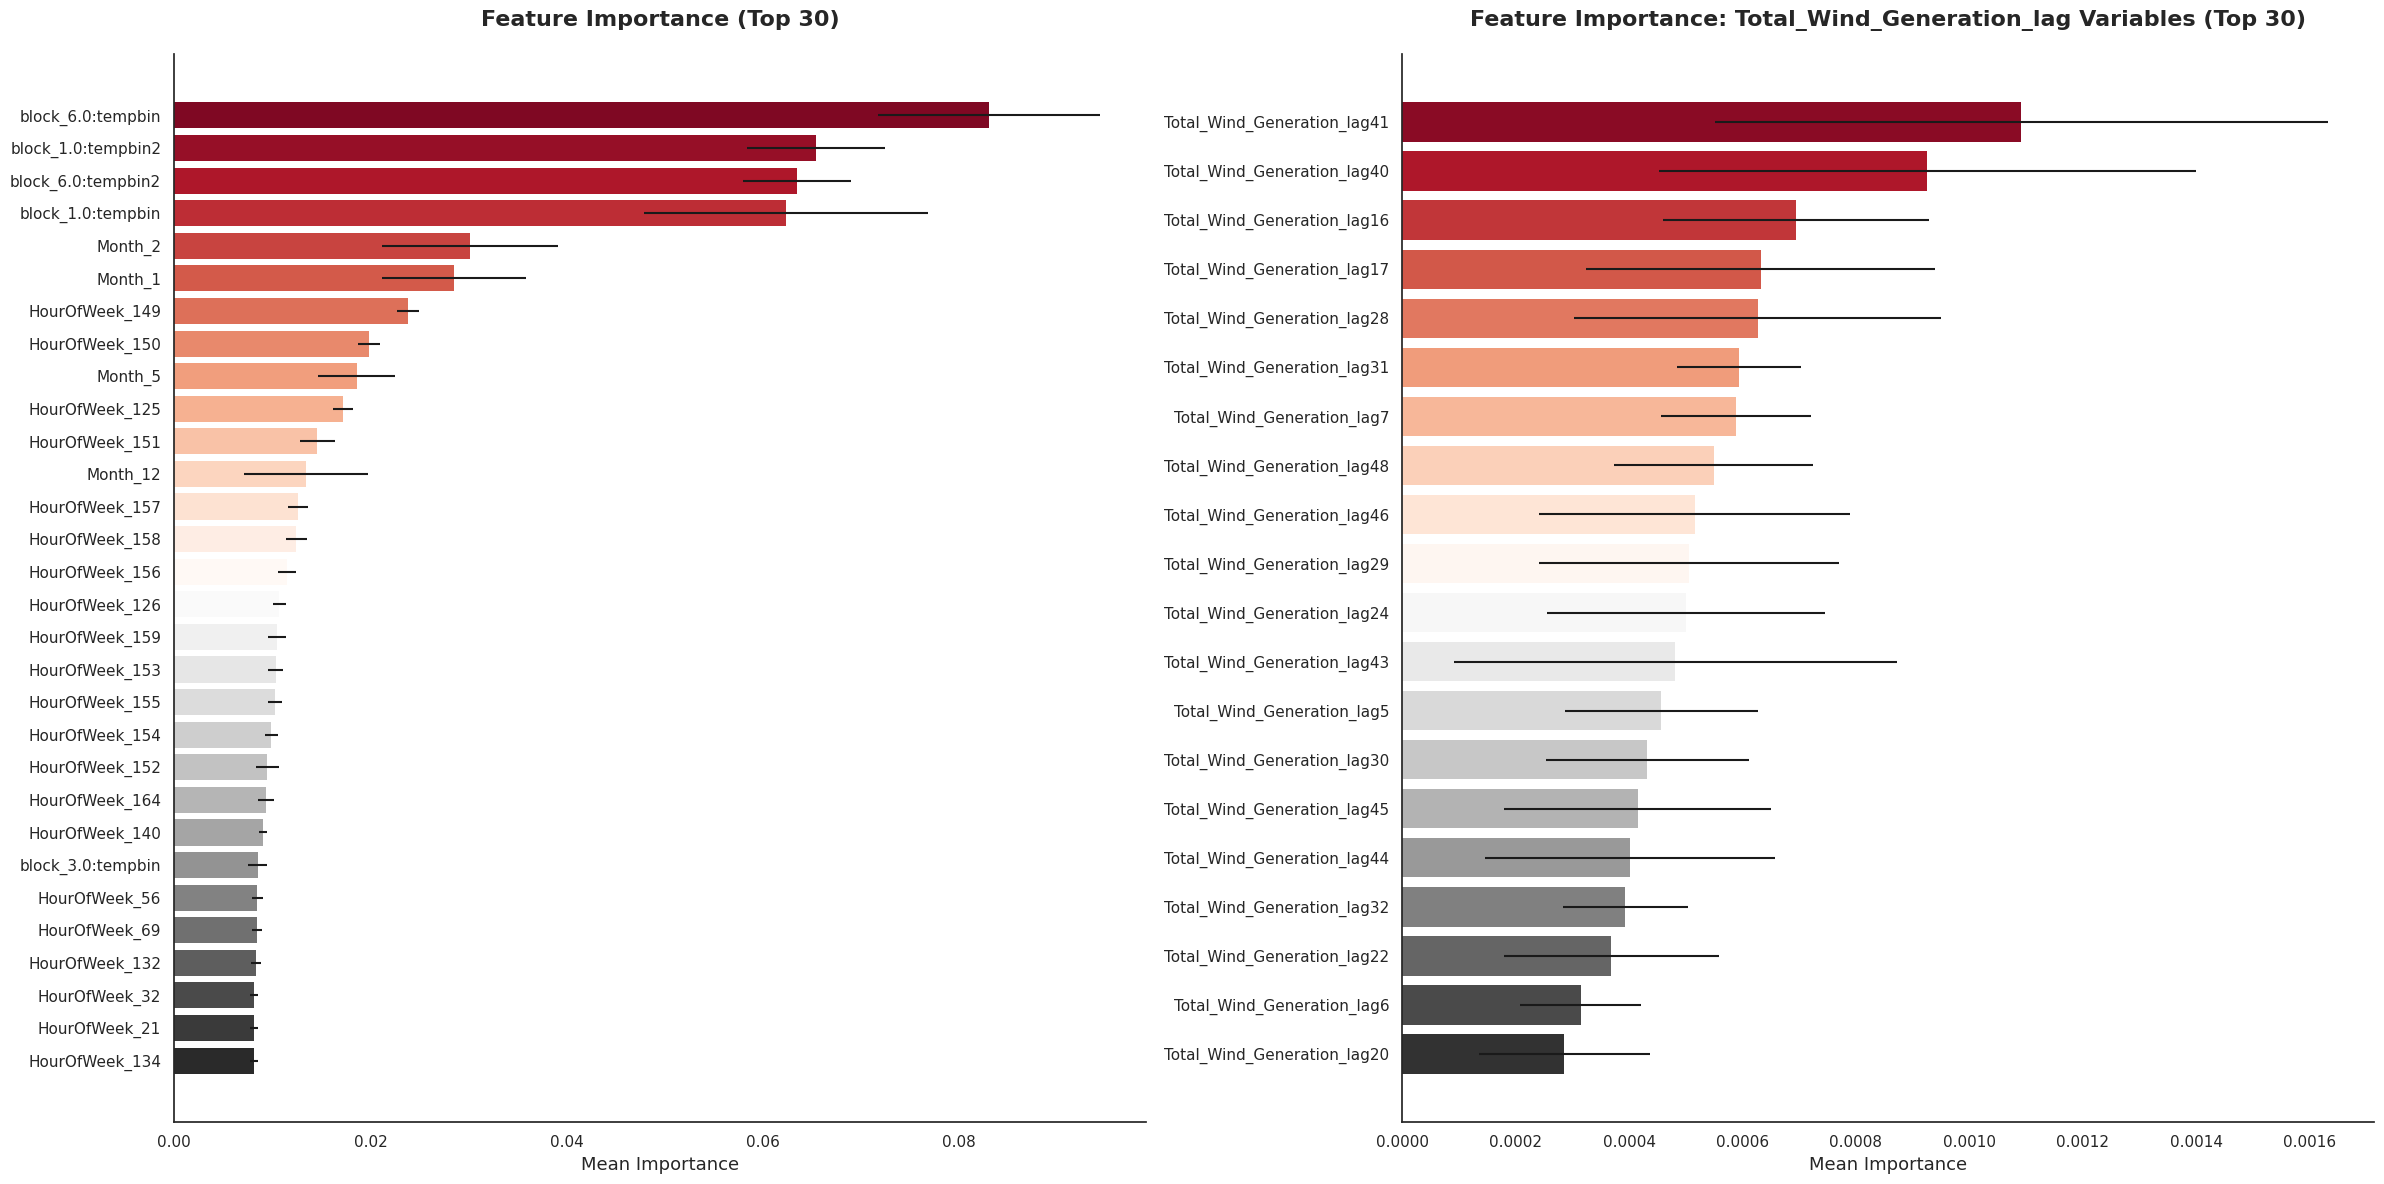

In [ ]:
top30_overall = lag_importance.sort_values(by='Mean Importance', ascending=False).head(30)
feat_importance_overall = top30_overall.sort_values(by='Mean Importance', ascending=True).reset_index(drop=True)

# Create a reversed RdGy color palette for overall plot
colors_overall = sns.color_palette("RdGy", len(feat_importance_overall))[::-1]
y_positions_overall = list(range(len(feat_importance_overall)))

# -----------------------------
# Data Preparation for Plot 2: Total_Wind_Generation_lag Variables (Top 30)
# Assume your DataFrame 'lag_importance' is already loaded with columns:
# ["Feature", "Mean Importance", "Std Importance"]

# Filter rows that start with "Total_Wind_Generation_lag"
filtered = lag_importance[lag_importance['Feature'].str.startswith("Total_Wind_Generation_lag")]

# Select the top 30 features by descending Mean Importance, then sort in ascending order
top30_lag = filtered.sort_values(by='Mean Importance', ascending=False).head(30)
feat_importance_lag = top30_lag.sort_values(by='Mean Importance', ascending=True).reset_index(drop=True)

# Create a reversed RdGy color palette for the lag features plot
colors_lag = sns.color_palette("RdGy", len(feat_importance_lag))[::-1]
y_positions_lag = list(range(len(feat_importance_lag)))

# -----------------------------
# Plotting: Create a combined horizontal figure with 2 subplots (1 row, 2 columns)
sns.set(style="white")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))  # 1 row, 2 columns

# Common bar height to increase vertical spacing between bars
bar_height = 0.8

# --- Plot 1: Overall Top 30 Features ---
ax1.barh(
    y_positions_overall,
    feat_importance_overall['Mean Importance'],
    xerr=feat_importance_overall['Std Importance'],
    color=colors_overall,
    edgecolor='none',
    height=bar_height
)
ax1.set_yticks(y_positions_overall)
ax1.set_yticklabels(feat_importance_overall['Feature'], fontsize=11)
ax1.set_title('Feature Importance (Top 30)', fontsize=16, weight='bold', pad=20)
ax1.set_xlabel('Mean Importance', fontsize=13)
ax1.tick_params(axis='x', labelsize=11)
sns.despine(ax=ax1, top=True, right=True, left=False, bottom=False)
ax1.grid(False)

# --- Plot 2: Total_Wind_Generation_lag Variables (Top 30) ---
ax2.barh(
    y_positions_lag,
    feat_importance_lag['Mean Importance'],
    xerr=feat_importance_lag['Std Importance'],
    color=colors_lag,
    edgecolor='none',
    height=bar_height
)
ax2.set_yticks(y_positions_lag)
ax2.set_yticklabels(feat_importance_lag['Feature'], fontsize=11)
ax2.set_title('Feature Importance: Total_Wind_Generation_lag Variables (Top 30)', fontsize=16, weight='bold', pad=20)
ax2.set_xlabel('Mean Importance', fontsize=13)
ax2.tick_params(axis='x', labelsize=11)
sns.despine(ax=ax2, top=True, right=True, left=False, bottom=False)
ax2.grid(False)

# Adjust layout, save, and show the combined plot.
plt.tight_layout()
plt.savefig("combined_feature_importance_horizontal.png", dpi=300)
plt.show()


#Smart meters

In [ ]:
# DK1                            coef   std err           t          P>|t|  \
DayAheadPriceEUR      -0.001758  0.000047  -37.418397  1.962370e-306
#DK2               coef   std err           t          P>|t|  \
DayAheadPriceEUR      -0.001841  0.000051  -36.251282  9.485311e-288


#EE

       coef   std err           t          P>|t|  \
DayAheadPriceEUR      -0.003985  0.000139  -28.707103  3.110768e-181

#ES
                coef   std err           t         P>|t|     2.5 %  \
DayAheadPriceEUR      -0.001148  0.000061  -18.814103  5.788024e-79 -0.001268

#"GR"
DayAheadPriceEUR       0.002226  0.000137  16.294411  1.081405e-59  0.001958

# "CZ"

coef   std err           t          P>|t|  \
DayAheadPriceEUR      -0.001501  0.000053  -28.434153  7.652266e-178

#"SK"
coef   std err           t         P>|t|     2.5 %  \
DayAheadPriceEUR       0.002217  0.000111   19.937944  1.907462e-88  0.001999

#'PT'
coef   std err           t         P>|t|     2.5 %  \
DayAheadPriceEUR      -0.000739  0.000107   -6.886475  5.719166e-12 -0.000949
#'SI'
 coef   std err           t          P>|t|  \
DayAheadPriceEUR       0.003958  0.000180   21.947897  9.070071e-107

#'CH'

  coef   std err          t         P>|t|     2.5 %  \
DayAheadPriceEUR      -0.000619  0.000056 -11.071830  1.718553e-28 -0.000728


#'AT'
 coef   std err           t         P>|t|     2.5 %  \
DayAheadPriceEUR      -0.001305  0.000081  -16.168116  8.464729e-59 -0.001463

#'LT'
 coef   std err          t         P>|t|     2.5 %  \
DayAheadPriceEUR      -0.001073  0.000062 -17.304607  4.342317e-67 -0.001194

#DE_LU
 coef   std err           t          P>|t|  \
DayAheadPriceEUR      -0.000758  0.000034  -22.558526  1.107525e-112

# IT_NORD
 coef   std err          t          P>|t|     2.5 %  \
DayAheadPriceEUR       0.002931  0.000095  30.765574  7.569880e-208  0.002744

# IT_SICI

coef   std err          t         P>|t|     2.5 %  \
DayAheadPriceEUR       0.000670  0.000074   9.056775  1.343639e-19  0.000525

# IT_SARD

coef   std err          t         P>|t|     2.5 %  \
DayAheadPriceEUR       0.001204  0.000116  10.333746  4.958532e-25  0.000976

#BE

coef   std err           t         P>|t|     2.5 %  \
DayAheadPriceEUR      -0.000718  0.000047  -15.325540  5.162365e-53 -0.000810

#IT_CNOR
 coef   std err          t          P>|t|     2.5 %  \
DayAheadPriceEUR       0.003855  0.000178  21.682425  3.006155e-104  0.003506

#IT_CSUD
coef   std err          t         P>|t|     2.5 %  \
DayAheadPriceEUR       0.000939  0.000157   5.983047  2.190022e-09  0.000631

# IT_SUD
 coef   std err          t         P>|t|     2.5 %  \
DayAheadPriceEUR       0.001243  0.000103  12.101279  1.039788e-33  0.001041

# FR
 coef   std err           t          P>|t|  \
DayAheadPriceEUR      -0.006115  0.000185  -33.074132  6.999709e-240

#RO

coef   std err           t         P>|t|     2.5 %  \
DayAheadPriceEUR      -0.001729  0.000091  -18.952336  4.224105e-80 -0.001908

#BG
coef   std err           t          P>|t|  \
DayAheadPriceEUR      -0.004502  0.000170  -26.546664  2.806394e-155

#HR
coef   std err         t         P>|t|     2.5 %  \
DayAheadPriceEUR      -0.000354  0.000096 -3.690303  2.239875e-04 -0.000543

#HU
 coef   std err          t         P>|t|     2.5 %  \
DayAheadPriceEUR       0.000499  0.000062   8.108205  5.137304e-16  0.000378

#PL
coef   std err          t          P>|t|     2.5 %  \
DayAheadPriceEUR       0.000295  0.000063   4.652556   3.278457e-06  0.000171

#IT_CALA

coef   std err           t          P>|t|  \
DayAheadPriceEUR      -0.002451  0.000087  -28.326825  1.615471e-176

#UA_BEI
coef   std err          t         P>|t|     2.5 %  \
DayAheadPriceEUR       0.007353  0.000514  14.297854  2.256610e-46  0.006345

#UA_IPS
coef   std err           t          P>|t|  \
DayAheadPriceEUR      -0.000974  0.000041  -23.724167  2.030828e-124

#SE_4
coef   std err           t          P>|t|  \
DayAheadPriceEUR      -0.001484  0.000044  -34.019740  1.137763e-253

#SE_1  coef   std err          t     P>|t|     2.5 %  \
DayAheadPriceEUR      -0.000456  0.000135  -3.384689  0.000713 -0.000721

#SE_3 coef   std err           t         P>|t|     2.5 %  \
DayAheadPriceEUR      -0.000527  0.000030  -17.609648  2.077336e-69 -0.000586

#SE_2 coef   std err           t     P>|t|     2.5 %  \
DayAheadPriceEUR      -0.000497  0.000156   -3.180632  0.001470 -0.000803

#FI coef   std err           t     P>|t|     2.5 %  \
DayAheadPriceEUR      -0.000096  0.000101   -0.955987  0.339079 -0.000294

#ME coef   std err         t     P>|t|     2.5 %  \
DayAheadPriceEUR       0.001621  0.001086  1.492910  0.135461 -0.000507

In [ ]:
data = {
    "Member State": ["DK", "SE", "FI", "EE", "ES", "NO", "LU", "LV", "IT", "FR",
                     "MT", "SI", "NL", "PT", "AT", "IE", "BE", "HR", "RO", "PL",
                     "SK", "LT", "HU", "CZ", "DE", "BG", "CY", "GR"],
    "Smart Meter roll-out_2022 (%)": [100, 100, 100, 100, 99, 99, 99, 98, 98, 92,
                                      92, 92, 89, 73, 68, 56, 22, 20, 19, 19,
                                      15, 12, 7, 3, 0, 0, 0, 0]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)


   Member State  Smart Meter roll-out_2022 (%)
0            DK                            100
1            SE                            100
2            FI                            100
3            EE                            100
4            ES                             99
5            NO                             99
6            LU                             99
7            LV                             98
8            IT                             98
9            FR                             92
10           MT                             92
11           SI                             92
12           NL                             89
13           PT                             73
14           AT                             68
15           IE                             56
16           BE                             22
17           HR                             20
18           RO                             19
19           PL                             19
20           

In [ ]:
data = {
    "Member State": ["DK", "SE", "FI", "EE", "ES", "NO", "LU", "LV", "IT", "FR",
                     "MT", "SI", "NL", "PT", "AT", "IE", "BE", "HR", "RO", "PL",
                     "SK", "LT", "HU", "CZ", "DE", "BG", "CY", "GR"],
    "Smart Meter roll-out_2022 (%)": [100, 100, 100, 100, 99, 99, 99, 98, 98, 92,
                                      92, 92, 89, 73, 68, 56, 22, 20, 19, 19,
                                      15, 12, 7, 3, 0, 0, 0, 0]
}
df_smart = pd.DataFrame(data)

# Elasticity coefficients from your regressions.
# For countries with multiple outputs, we average the coefficients.
# For example, for Denmark (DK): average(DK1 = -0.001758, DK2 = -0.001841) ≈ -0.00180
# For Italy (IT): average of IT_NORD (0.002931), IT_SICI (0.000670), IT_SARD (0.001204), IT_CNOR (0.003855),
# IT_CSUD (0.000939), IT_SUD (0.001243) ≈ 0.001807

elasticity_data = {
    "Member State": ["DK", "EE", "ES", "GR", "CZ", "SK", "PT", "SI", "AT", "LT", "DE", "BE", "FR", "RO", "BG", "IT",
                    "HR", "HU", "PL", "FI", "ME",'SE'],
    "Elasticity": [
        -0.00180,   # DK (averaged DK1 & DK2)
        -0.003985,  # EE
        -0.001148,  # ES
         0.002226,  # GR
        -0.001501,  # CZ
         0.002217,  # SK
        -0.000739,  # PT
         0.003958,  # SI
        -0.001305,  # AT
        -0.001073,  # LT
        -0.000758,  # DE (from DE_LU)
        -0.000718,  # BE
        -0.006115,  # FR
        -0.001729,  # RO
        -0.004502,  # BG
         0.001807,   # IT (averaged Italy coefficients)
        -0.000354, # HR
        0.000499, # HU
        0.000295,# PL
         -0.000096, # FI
        0.001621,  # ME
        -0.000741  # SE average
    ]
}
df_coef = pd.DataFrame(elasticity_data)

# Merge the smart meter rollout data with the elasticity coefficients.
# The merge is done on "Member State"; we use an inner join so only countries with both measurements are included.
df_merged = pd.merge(df_smart, df_coef, on="Member State", how="inner")

print("Merged Data:")
print(df_merged)


Merged Data:
   Member State  Smart Meter roll-out_2022 (%)  Elasticity
0            DK                            100   -0.001800
1            SE                            100   -0.000741
2            FI                            100   -0.000096
3            EE                            100   -0.003985
4            ES                             99   -0.001148
5            IT                             98    0.001807
6            FR                             92   -0.006115
7            SI                             92    0.003958
8            PT                             73   -0.000739
9            AT                             68   -0.001305
10           BE                             22   -0.000718
11           HR                             20   -0.000354
12           RO                             19   -0.001729
13           PL                             19    0.000295
14           SK                             15    0.002217
15           LT                            

In [ ]:
X = df_merged["Smart Meter roll-out_2022 (%)"]
y = df_merged["Elasticity"]

# Add a constant term for the intercept.
X = sm.add_constant(X)

# Fit the ordinary least squares (OLS) regression model.
model = sm.OLS(y, X).fit()

# Print the regression summary.
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             Elasticity   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.042
Method:                 Least Squares   F-statistic:                    0.1974
Date:                Wed, 16 Apr 2025   Prob (F-statistic):              0.662
Time:                        04:50:26   Log-Likelihood:                 98.363
No. Observations:                  21   AIC:                            -192.7
Df Residuals:                      19   BIC:                            -190.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [ ]:

data = {
    "Member State": ["DK", "SE", "FI", "EE", "ES", "NO", "LU", "LV", "IT", "FR",
                     "MT", "SI", "NL", "PT", "AT", "IE", "BE", "HR", "RO", "PL",
                     "SK", "LT", "HU", "CZ", "DE", "BG", "CY", "GR"],
    "Smart Meter roll-out_2022 (%)": [100, 100, 100, 100, 99, 99, 99, 98, 98, 92,
                                      92, 92, 89, 73, 68, 56, 22, 20, 19, 19,
                                      15, 12, 7, 3, 0, 0, 0, 0]
}
df_smart = pd.DataFrame(data)

# Convert percentages to proportions by dividing by 100
df_smart["Smart Meter roll-out (proportion)"] = df_smart["Smart Meter roll-out_2022 (%)"] / 100

elasticity_data = {
    "Member State": ["DK", "EE", "ES", "GR", "CZ", "SK", "PT", "SI", "AT", "LT", "DE", "BE", "FR", "RO", "BG", "IT",
                    "HR", "HU", "PL", "FI", "ME",'SE'],
    "Elasticity": [
        -0.00180,   # DK (averaged DK1 & DK2)
        -0.003985,  # EE
        -0.001148,  # ES
         0.002226,  # GR
        -0.001501,  # CZ
         0.002217,  # SK
        -0.000739,  # PT
         0.003958,  # SI
        -0.001305,  # AT
        -0.001073,  # LT
        -0.000758,  # DE (from DE_LU)
        -0.000718,  # BE
        -0.006115,  # FR
        -0.001729,  # RO
        -0.004502,  # BG
         0.001807,   # IT (averaged Italy coefficients)
        -0.000354, # HR
        0.000499, # HU
        0.000295,# PL
         -0.000096, # FI
        0.001621,  # ME
        -0.000741  # SE average
    ]
}
df_coef = pd.DataFrame(elasticity_data)

# Merge the two dataframes based on the common "Member State"
df_merged = pd.merge(df_smart, df_coef, on="Member State", how="inner")

print("Merged Data:")
print(df_merged)

# Compute the Pearson correlation between the smart meter rollout (proportion) and elasticity
corr_value = df_merged[["Smart Meter roll-out (proportion)", "Elasticity"]].corr().iloc[0, 1]
print("\nPearson correlation between Smart Meter roll-out (proportion) and Elasticity:")
print(corr_value)


Merged Data:
   Member State  Smart Meter roll-out_2022 (%)  \
0            DK                            100   
1            SE                            100   
2            FI                            100   
3            EE                            100   
4            ES                             99   
5            IT                             98   
6            FR                             92   
7            SI                             92   
8            PT                             73   
9            AT                             68   
10           BE                             22   
11           HR                             20   
12           RO                             19   
13           PL                             19   
14           SK                             15   
15           LT                             12   
16           HU                              7   
17           CZ                              3   
18           DE                      

In [ ]:
import statsmodels.api as sm

# Define the dependent and independent variables.
X = df_merged["Smart Meter roll-out (proportion)"]
y = df_merged["Elasticity"]

# Add a constant term for the intercept.
X = sm.add_constant(X)

# Fit the ordinary least squares (OLS) regression model.
model = sm.OLS(y, X).fit()

# Print the regression summary.
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             Elasticity   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.042
Method:                 Least Squares   F-statistic:                    0.1974
Date:                Wed, 16 Apr 2025   Prob (F-statistic):              0.662
Time:                        04:51:21   Log-Likelihood:                 98.363
No. Observations:                  21   AIC:                            -192.7
Df Residuals:                      19   BIC:                            -190.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

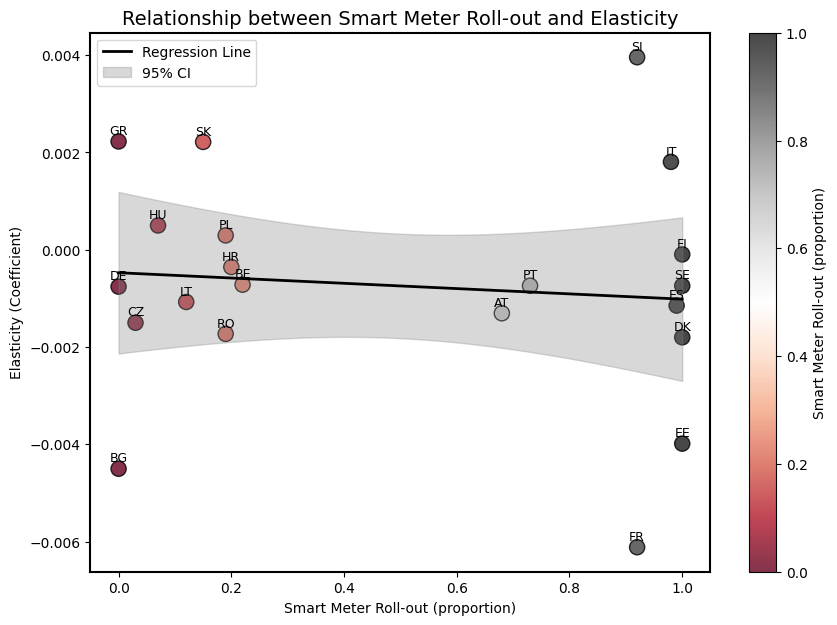

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
fig.patch.set_facecolor('white')  # Figure background white
ax.set_facecolor('white')         # Axes background white

# Set black borders (spines) around the plot
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

# Optionally, ensure tick marks and labels are in black
ax.tick_params(colors='black')

# Scatter plot with RdGy colormap
scatter = ax.scatter(df_merged["Smart Meter roll-out (proportion)"],
                     df_merged["Elasticity"],
                     c=df_merged["Smart Meter roll-out (proportion)"],
                     cmap="RdGy", s=120, edgecolor='black', alpha=0.8)

# Fit a linear regression using statsmodels
X = sm.add_constant(df_merged["Smart Meter roll-out (proportion)"])
model = sm.OLS(df_merged["Elasticity"], X).fit()

# Generate x-values for plotting the regression line
x_vals = np.linspace(df_merged["Smart Meter roll-out (proportion)"].min(),
                     df_merged["Smart Meter roll-out (proportion)"].max(), 100)
X_pred = sm.add_constant(x_vals)
y_pred = model.predict(X_pred)

# Get the 95% confidence intervals for the predictions
pred = model.get_prediction(X_pred)
pred_ci = pred.conf_int()

# Plot the regression line and the confidence interval band
ax.plot(x_vals, y_pred, color='black', lw=2, label='Regression Line')
ax.fill_between(x_vals, pred_ci[:, 0], pred_ci[:, 1], color='gray', alpha=0.3, label='95% CI')

# Add a colorbar to indicate the smart meter rollout proportion
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Smart Meter Roll-out (proportion)')

# Annotate each data point with the corresponding country code
for idx, row in df_merged.iterrows():
    ax.annotate(row["Member State"],
                (row["Smart Meter roll-out (proportion)"], row["Elasticity"]),
                textcoords="offset points", xytext=(0, 5), ha='center', fontsize=9)

# Set axis labels and title, and add a legend
ax.set_xlabel("Smart Meter Roll-out (proportion)")
ax.set_ylabel("Elasticity (Coefficient)")
ax.set_title("Relationship between Smart Meter Roll-out and Elasticity", fontsize=14)
ax.legend()

plt.show()